In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy
from sklearn.model_selection import train_test_split
import gensim
import os
import collections
import smart_open
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine, euclidean
import re
import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression

from segment_data import save_in_pkl
from pair_data import read_in_pkl

In [3]:
class Doc2VecModeler(object):
    '''
    Uses Gensim's Doc2Vec model to keep track of different model variations for comparison
    '''
    def __init__(self, model_name, train_corpus, training_corpus_name,
                 vector_size=100, dm=1, min_count=2, epochs=100):
        self.model_name = model_name
        self.train_corpus = train_corpus
        self.n_training_docs = len(self.train_corpus)
        self.training_corpus_name = training_corpus_name
        self.vector_size = vector_size
        self.dm = dm
        self.min_count = min_count
        self.epochs = epochs

        self.inferred_vecs = {'docs': [], 'vecs': []}

    def fit_model(self, verbose=False):
        model = gensim.models.doc2vec.Doc2Vec(vector_size=self.vector_size,
                                              dm=self.dm,
                                              min_count=self.min_count,
                                              epochs=self.epochs)
        model.build_vocab(self.train_corpus)
        model.train(self.train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
        if verbose:
            print("Model training complete!")
        self.model = model
        # return model

    def calc_self_recognition_ability(self):
        # ability to recognize a training doc as its own best match
        model = self.model
        ranks = []
        second_ranks = []
        for doc_id in range(self.n_training_docs):
            doc = self.train_corpus[doc_id].words
            inferred_vector = self.model.infer_vector(doc, epochs=self.epochs)

            self.inferred_vecs['docs'].append(doc)
            self.inferred_vecs['vecs'].append(inferred_vector)

            sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
            #gives you all document tags and their cosine similarity
            # Gets its own self-ranking
            rank = [docid for docid, sim in sims].index(doc_id)
            ranks.append(rank)
            second_ranks.append(sims[1])
        # Let's count how each document ranks with respect to the training corpus
        rank_counter = collections.Counter(ranks)
        # Results vary between runs due to random seeding and very small corpus
        self.rank_counter = rank_counter
        self.n_self_recognized = self.rank_counter[0]
        self.self_recog_rate = self.n_self_recognized / self.n_training_docs
        self.greater_than_95 = self.self_recog_rate >= 0.95

    def calculate_pair_sims_array(self, pairings_df, is_train=True):
#         is_train = pairings_df == train_pairings_df
        ref_vecs = []
        tate_vecs = []
        rt_cs = []
        rt_ed = []
        for row in pairings_df.index:
            ref_doc = pairings_df.loc[row,['ref_pp_text']][0]
            tate_doc = pairings_df.loc[row,['tate_pp_text']][0]

            inf_ref_vec = self.model.infer_vector(ref_doc, epochs=self.epochs).reshape(-1, 1)
            inf_tate_vec = self.model.infer_vector(tate_doc, epochs=self.epochs).reshape(-1, 1)

            ref_vecs.append(inf_ref_vec)
            tate_vecs.append(inf_tate_vec)

            cs = 1 - cosine(inf_ref_vec, inf_tate_vec)
            ed = euclidean(inf_ref_vec, inf_tate_vec)

            rt_cs.append(cs)
            rt_ed.append(ed)


        calc_pairings_df = pairings_df.copy()
        calc_pairings_df['ref_vecs'] = ref_vecs
        calc_pairings_df['tate_vecs'] = tate_vecs
        calc_pairings_df['pair_cs'] = rt_cs
        calc_pairings_df['pair_ed'] = rt_ed

        is_true_pair = calc_pairings_df['is_pair'] == 1

        avg_true_pair_cs = calc_pairings_df[is_true_pair]['pair_cs'].mean()
        avg_false_pair_cs = calc_pairings_df[~is_true_pair]['pair_cs'].mean()
        max_true_pair_cs = calc_pairings_df[is_true_pair]['pair_cs'].max()
        max_false_pair_cs = calc_pairings_df[~is_true_pair]['pair_cs'].max()
        min_true_pair_cs = calc_pairings_df[is_true_pair]['pair_cs'].min()
        min_false_pair_cs = calc_pairings_df[~is_true_pair]['pair_cs'].min()

        pair_cs_stats = {'avg_tru':avg_true_pair_cs, 'avg_false':avg_false_pair_cs, 'max_tru':max_true_pair_cs, 'max_false':max_false_pair_cs, 'min_tru':min_true_pair_cs, 'min_false':min_false_pair_cs}

        avg_true_pair_ed = calc_pairings_df[is_true_pair]['pair_ed'].mean()
        avg_false_pair_ed = calc_pairings_df[~is_true_pair]['pair_ed'].mean()
        max_true_pair_ed = calc_pairings_df[is_true_pair]['pair_ed'].max()
        max_false_pair_ed = calc_pairings_df[~is_true_pair]['pair_ed'].max()
        min_true_pair_ed = calc_pairings_df[is_true_pair]['pair_ed'].min()
        min_false_pair_ed = calc_pairings_df[~is_true_pair]['pair_ed'].min()

        pair_ed_stats = {'avg_tru':avg_true_pair_ed, 'avg_false':avg_false_pair_ed, 'max_tru':max_true_pair_ed, 'max_false':max_false_pair_ed, 'min_tru':min_true_pair_ed, 'min_false':min_false_pair_ed}

        if is_train:
            self.tr_pairings_df = calc_pairings_df.copy()
            self.train_true_cs = calc_pairings_df[calc_pairings_df['is_pair'] == 1]['pair_cs']
            self.train_false_cs = calc_pairings_df[calc_pairings_df['is_pair'] == 0]['pair_cs']
            self.train_true_ed = calc_pairings_df[calc_pairings_df['is_pair'] == 1]['pair_ed']
            self.train_false_ed = calc_pairings_df[calc_pairings_df['is_pair'] == 0]['pair_ed']
            self.tr_cs_pairings_stats = pair_cs_stats
            self.tr_ed_pairings_stats = pair_ed_stats
        else:
            self.tst_pairings_df = calc_pairings_df.copy()
            self.test_true_cs = calc_pairings_df[calc_pairings_df['is_pair'] == 1]['pair_cs']
            self.test_false_cs = calc_pairings_df[calc_pairings_df['is_pair'] == 0]['pair_cs']
            self.test_true_ed = calc_pairings_df[calc_pairings_df['is_pair'] == 1]['pair_ed']
            self.test_false_ed = calc_pairings_df[calc_pairings_df['is_pair'] == 0]['pair_ed']
            self.tst_cs_pairings_stats = pair_cs_stats
            self.tst_ed_pairings_stats = pair_ed_stats

    def calc_tt_hypothesis_test(self, for_train_pairings=True, for_cs=True):
        pairs_df = self.tr_pairings_df if for_train_pairings else self.tst_pairings_df
        sim_col = 'pair_cs' if for_cs else 'pair_ed'
        true_sims = pairs_df[pairs_df['is_pair'] == 1][sim_col]
        false_sims = pairs_df[pairs_df['is_pair'] == 0][sim_col]
        stat, p = ttest_ind(true_sims, false_sims)
        # need to include: logic for cs/ed!
        if for_train_pairings:
            if for_cs:
                self.cs_train_stat = stat
                self.cs_train_p_val = p
                self.cs_is_train_significant = p < 0.01
            else:
                self.ed_train_stat = stat
                self.ed_train_p_val = p
                self.ed_is_train_significant = p < 0.01
        else:
            if for_cs:
                self.cs_test_stat = stat
                self.cs_test_p_val = p
                self.cs_is_test_significant = p < 0.01
            else:
                self.ed_test_stat = stat
                self.ed_test_p_val = p
                self.ed_is_test_significant = p < 0.01

    def plot_sim_distribution(self, use_train=True, use_cs=True, save_fig=False):
        if use_train:
            tru_pairs = self.train_true_cs if use_cs else self.train_true_ed
            non_pairs = self.train_false_cs if use_cs else self.train_false_ed
        else:
            tru_pairs = self.test_true_cs if use_cs else self.test_true_ed
            non_pairs = self.test_false_cs if use_cs else self.test_false_ed

        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(111)

        title = "Distributions of DocVec Similarity - Model:" + self.model_name

        ax.set_title(title, fontsize=18)

        plt.hist(non_pairs, bins=100, color='red', alpha=0.3, label='mismatched pairs')
        plt.hist(tru_pairs, bins=100, color='blue', alpha=0.3, label='true pairs')

        plt.axvline(x=tru_pairs.mean(), c='blue', alpha=0.6, linewidth=3)
        plt.axvline(x=non_pairs.mean(), c='red', alpha=0.6, linewidth=3)
        # plt.axhline(y=0, c='red', alpha=0.3)

        dist = "Cosine Similarity" if use_cs else "Euclidean Distance"
        x_label = dist + ' of Annotation & Lyric DocVectors'

        ax.set_xlabel(x_label, fontsize=16)
        ax.set_ylabel('Frequency', fontsize=16)

        ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

        plt.show()

        if save_fig:
            shorthand_dist = 'cs' if use_cs else 'ed'
            fig.savefig('../images/{0}_dist_{1}.png'.format(shorthand_dist, self.model_name))


In [4]:
class DocVecModelEvaluator(object):
    '''
    Uses Gensim's Doc2Vec model to keep track of different model variations for comparison
    '''
    def __init__(self):
        self.eval_areas_dict = {'model':0, 'self_recog_rate':0,'cs_train_p_val':0, 'cs_test_p_val':0, 'ed_train_p_val':0, 'ed_test_p_val':0, 'cs_is_train_significant':0, 'cs_is_test_significant':0, 'ed_is_train_significant':0, 'ed_is_test_significant':0, 'tr_cs_pairings_stats': 0, 'tst_cs_pairings_stats':0, 'tr_ed_pairings_stats':0, 'tst_ed_pairings_stats':0}
        self.eval_dict = dict()

    def train_new_model(self, model_name, train_corpus, train_corp_name, vector_size):
        model = Doc2VecModeler(model_name, train_corpus, train_corp_name, vector_size=vector_size)
        model.fit_model(verbose=True)

        model.calc_self_recognition_ability()

        model.calculate_pair_sims_array(train_pairings_df, is_train=True)
        model.calculate_pair_sims_array(test_pairings_df, is_train=False)

        model.calc_tt_hypothesis_test(for_train_pairings=True, for_cs=True)
        model.calc_tt_hypothesis_test(for_train_pairings=False, for_cs=True)
        model.calc_tt_hypothesis_test(for_train_pairings=True, for_cs=False)
        model.calc_tt_hypothesis_test(for_train_pairings=False, for_cs=False)

        model.plot_sim_distribution(use_train=True, use_cs=True, save_fig=True)
        model.plot_sim_distribution(use_train=False, use_cs=True, save_fig=True)
        model.plot_sim_distribution(use_train=True, use_cs=False, save_fig=True)
        model.plot_sim_distribution(use_train=False, use_cs=False, save_fig=True)

        self.update_stats(model)

    def update_stats(self, model):
        model_eval_stats = self.eval_areas_dict.copy()
        model_eval_stats['model'] = model
        model_eval_stats['self_recog_rate'] = model.self_recog_rate
        model_eval_stats['cs_train_p_val'] = model.cs_train_p_val
        model_eval_stats['cs_test_p_val'] = model.cs_test_p_val
        model_eval_stats['ed_train_p_val'] = model.ed_train_p_val
        model_eval_stats['ed_test_p_val'] = model.ed_test_p_val
        model_eval_stats['cs_is_train_significant'] = model.cs_is_train_significant
        model_eval_stats['cs_is_test_significant'] = model.cs_is_test_significant
        model_eval_stats['ed_is_train_significant'] = model.ed_is_train_significant
        model_eval_stats['ed_is_test_significant'] = model.ed_is_test_significant

        # model_eval_stats['tr_cs_pairings_stats'] = model.tr_cs_pairings_stats
        # model_eval_stats['tst_cs_pairings_stats'] = model.tst_cs_pairings_stats
        # model_eval_stats['tr_ed_pairings_stats'] = model.tr_ed_pairings_stats
        # model_eval_stats['tst_ed_pairings_stats'] = model.tst_ed_pairings_stats

        model_eval_stats['tr_cs_true_mean'] = model.tr_cs_pairings_stats['avg_tru']
        model_eval_stats['tr_cs_false_mean'] = model.tr_cs_pairings_stats['avg_false']

        model_eval_stats['tst_cs_true_mean'] = model.tst_cs_pairings_stats['avg_tru']
        model_eval_stats['tst_cs_false_mean'] = model.tst_cs_pairings_stats['avg_false']

        model_eval_stats['tr_ed_true_mean'] = model.tr_ed_pairings_stats['avg_tru']
        model_eval_stats['tr_ed_false_mean'] = model.tr_ed_pairings_stats['avg_false']

        model_eval_stats['tst_ed_true_mean'] = model.tst_ed_pairings_stats['avg_tru']
        model_eval_stats['tst_ed_false_mean'] = model.tst_ed_pairings_stats['avg_false']

        self.eval_dict[model.model_name] = model_eval_stats
        self.eval_cols = self.eval_dict[model.model_name].keys()

    def print_model_eval_stats(self):
        eval_df = pd.DataFrame.from_dict(self.eval_dict, orient='index', columns=self.eval_cols)
        print(eval_df)
        self.eval_df = eval_df
        return eval_df


In [5]:
corpus_dict = read_in_pkl('corpus_dict')
train_df = read_in_pkl('train_df')
test_df = read_in_pkl('test_df')
lookup_dicts = read_in_pkl('lookup_dicts')
pcorpuses = read_in_pkl('pcorpuses')
train_pairings_df = read_in_pkl('train_pairings_df')
test_pairings_df = read_in_pkl('test_pairings_df')

artists = lookup_dicts[0]
doc_rt_train_dict = lookup_dicts[1]
doc_rt_test_dict = lookup_dicts[2]
rt_doc_train_dict = lookup_dicts[3]
rt_doc_test_dict = lookup_dicts[4]
rt_in_train_dict = lookup_dicts[5]
artist_rt_dict = lookup_dicts[6]
rt_artist_dict = lookup_dicts[7]
song_rt_dict = lookup_dicts[8]
rt_song_dict = lookup_dicts[9]
song_id_to_title_dict = lookup_dicts[10]

ref_train_pcorpus = pcorpuses[0]
ref_test_pcorpus = pcorpuses[1]
tate_train_pcorpus = pcorpuses[2]
tate_test_pcorpus = pcorpuses[3]
rt_train_pcorpus = pcorpuses[4]
rt_test_pcorpus = pcorpuses[5]
rt_tagged_train_pcorpus = pcorpuses[6]
rt_tagged_test_pcorpus = pcorpuses[7]

# model_specs = {'training_corpus':[ref_train_pcorpus, tate_train_pcorpus, rt_train_pcorpus, rt_tagged_train_pcorpus], 'vector_size':[50, 100, 200, 300], 'window':[3, 5, 7], 'epochs':[30, 50, 70, 90, 110, 130]}

model_specs = {'training_corpus':[ref_train_pcorpus, tate_train_pcorpus, rt_train_pcorpus, rt_tagged_train_pcorpus], 'vector_size':[50, 100, 200], 'window':[3, 5, 7], 'epochs':[25, 50, 110]}


Model training complete!


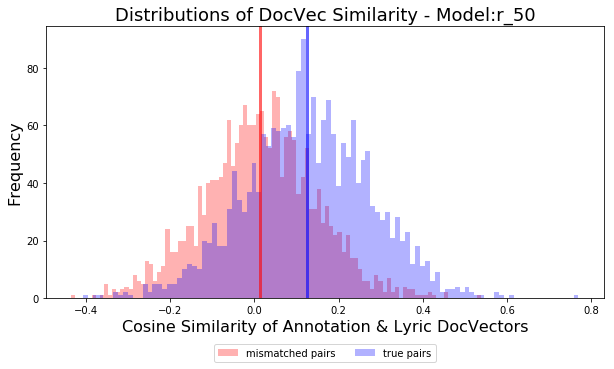

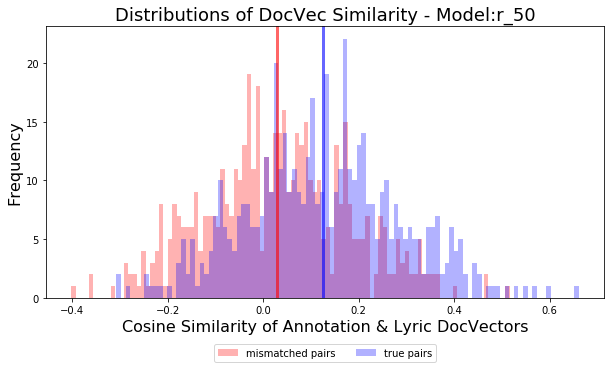

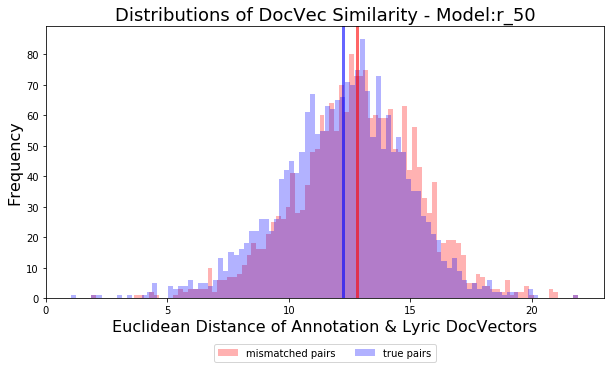

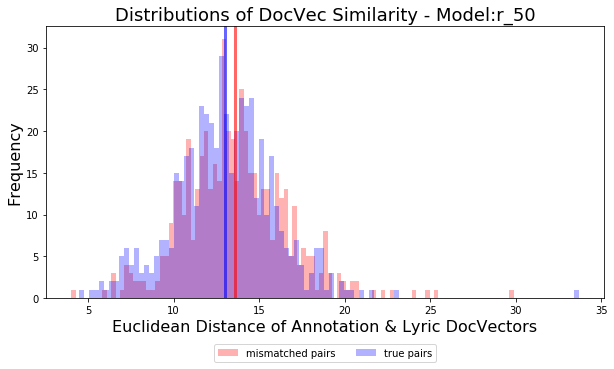

Model training complete!


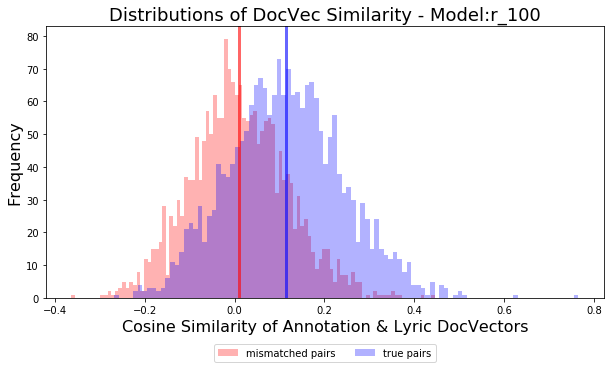

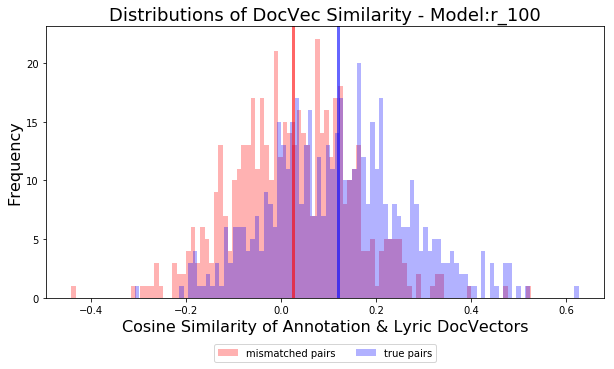

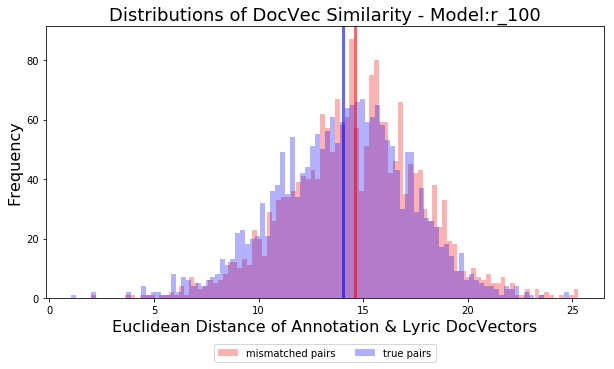

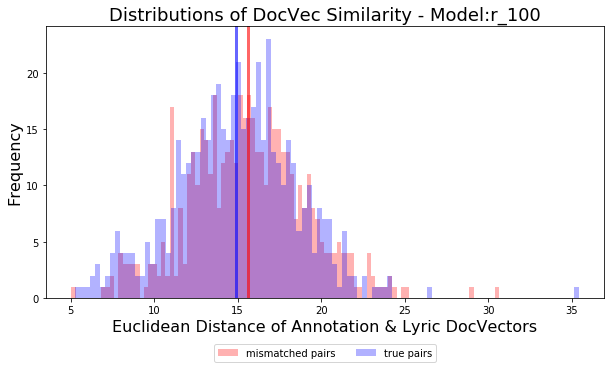

Model training complete!


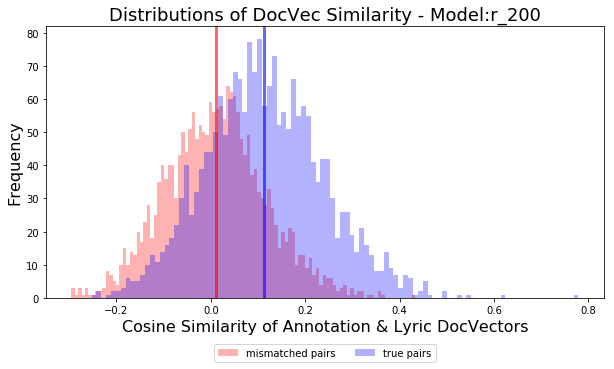

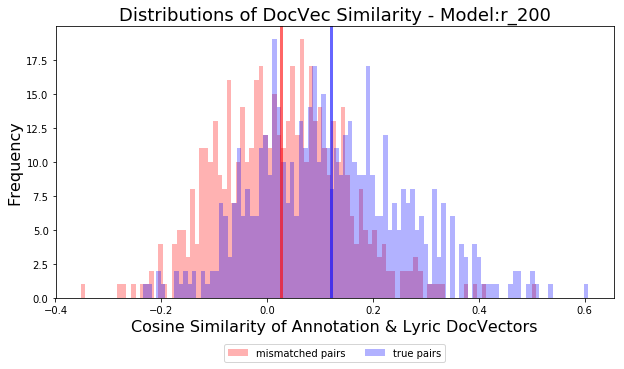

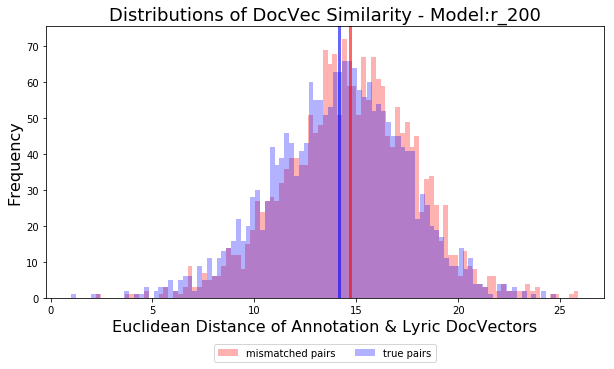

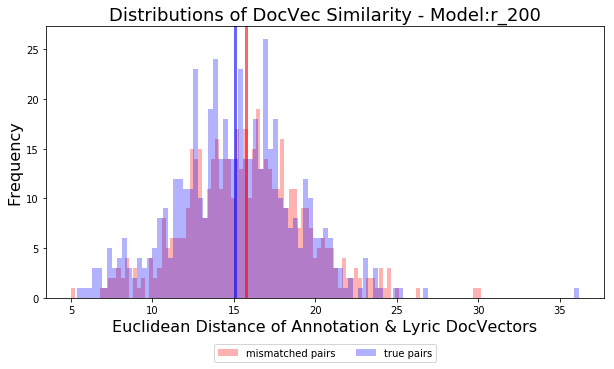

Model training complete!


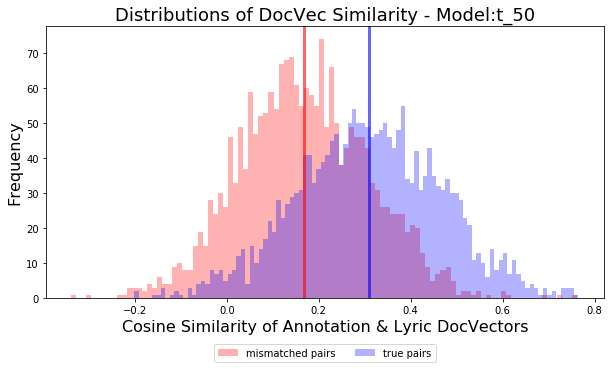

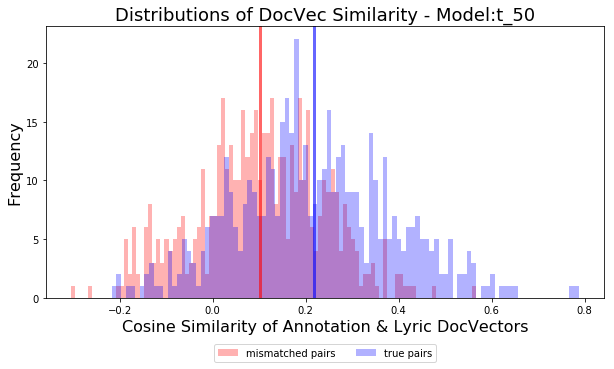

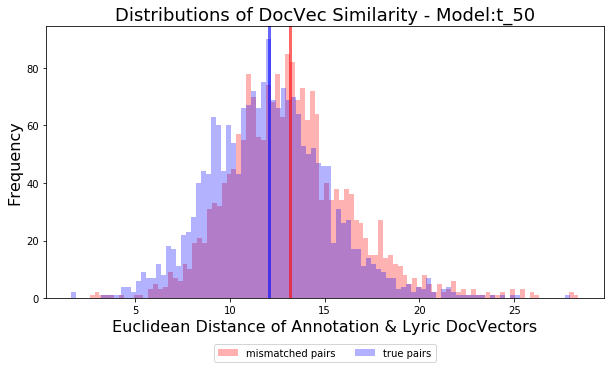

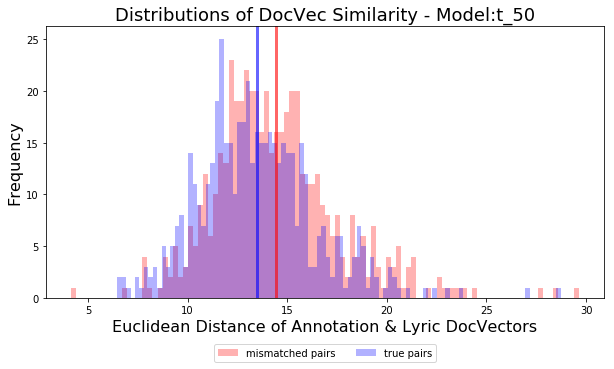

Model training complete!


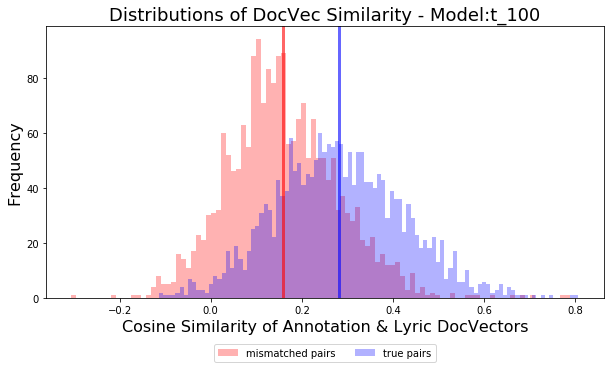

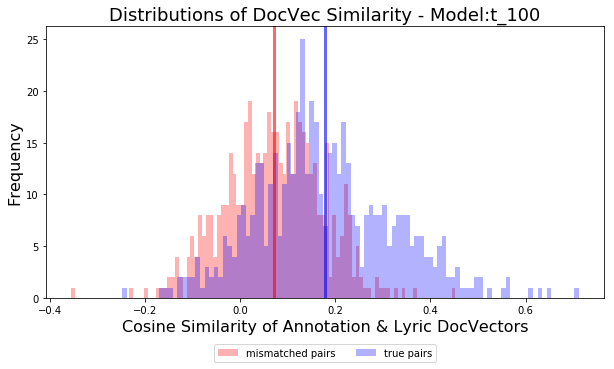

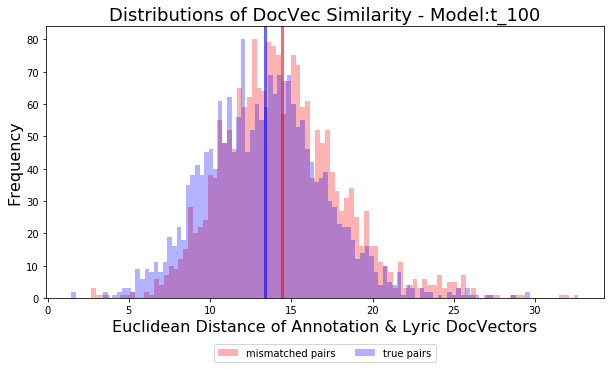

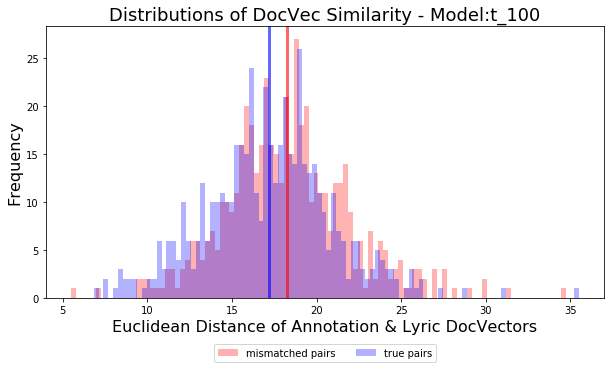

Model training complete!


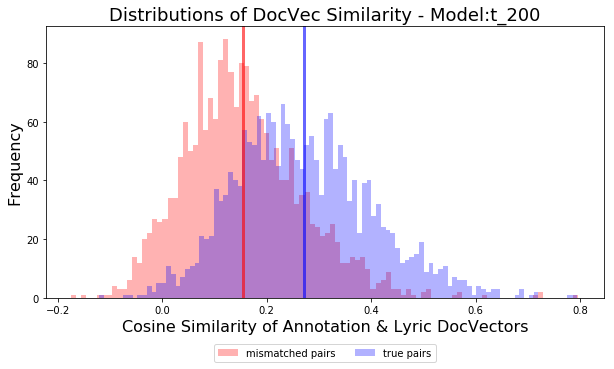

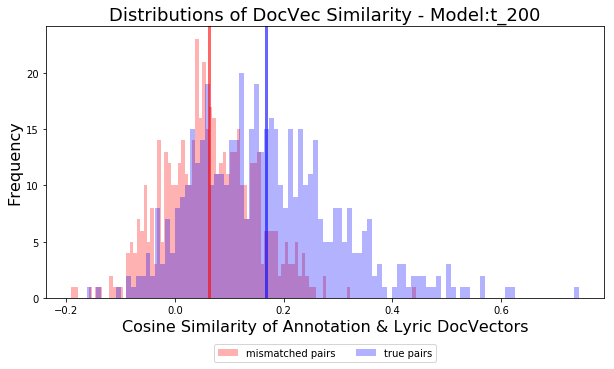

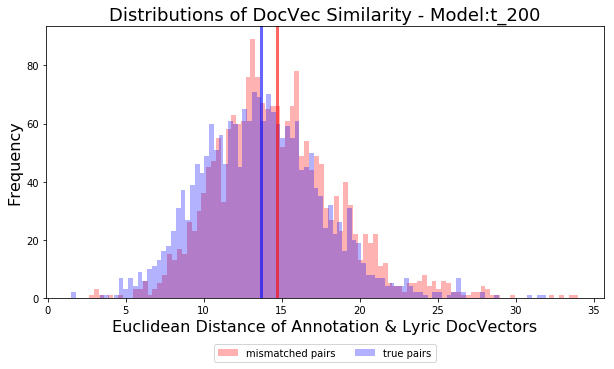

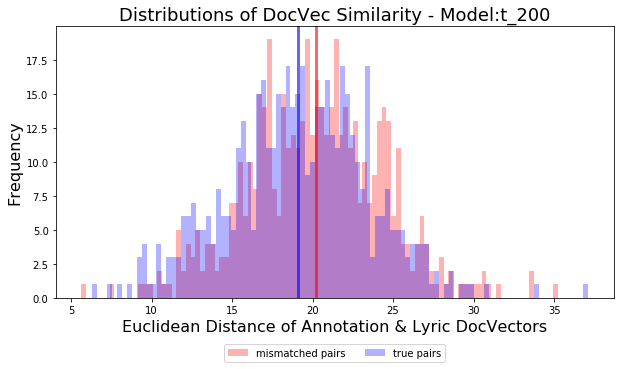

Model training complete!


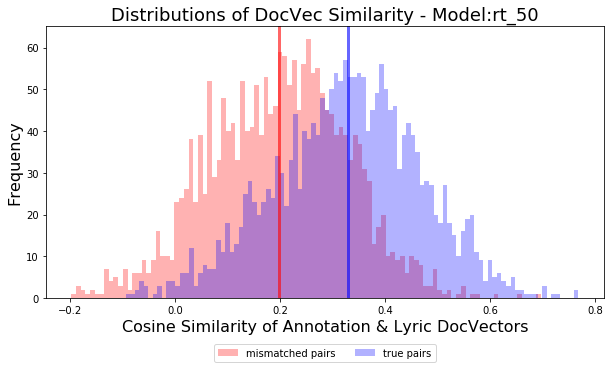

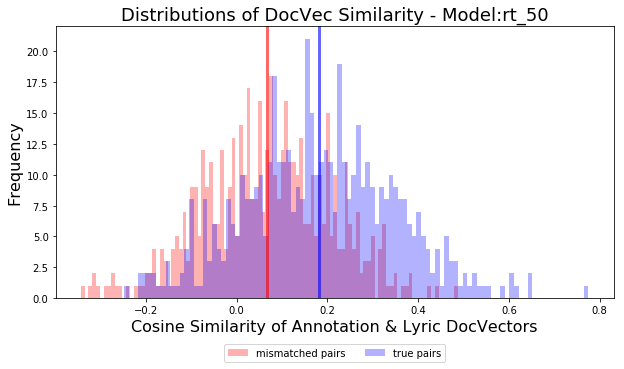

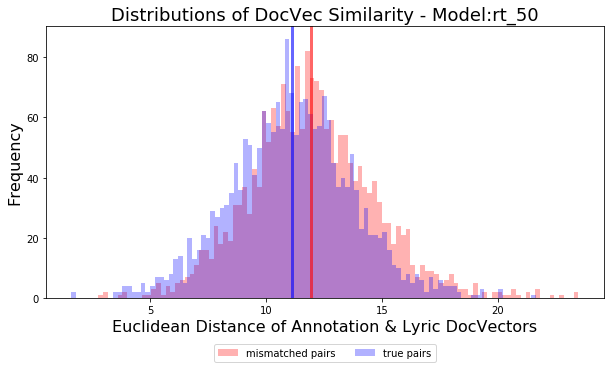

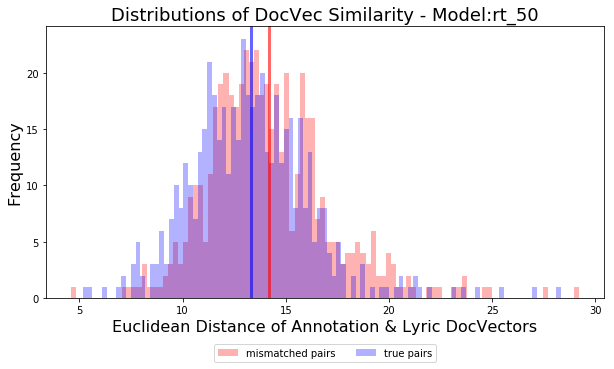

Model training complete!


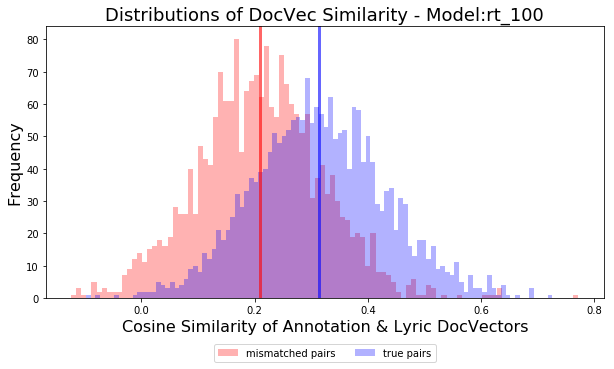

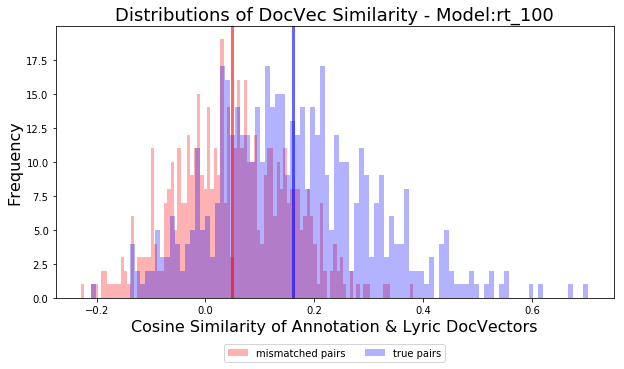

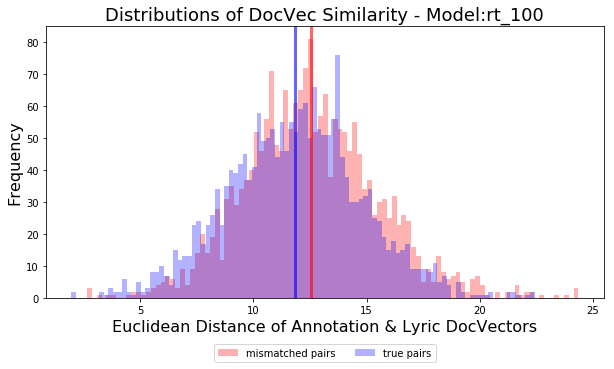

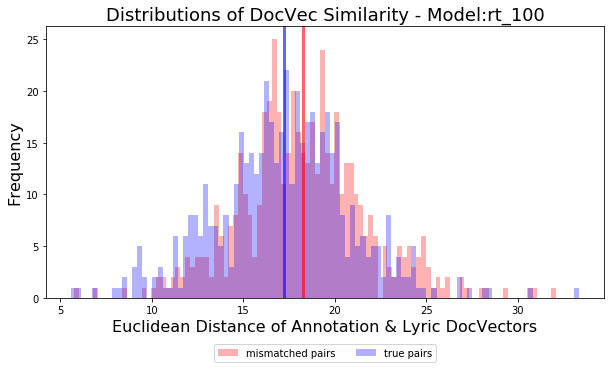

Model training complete!


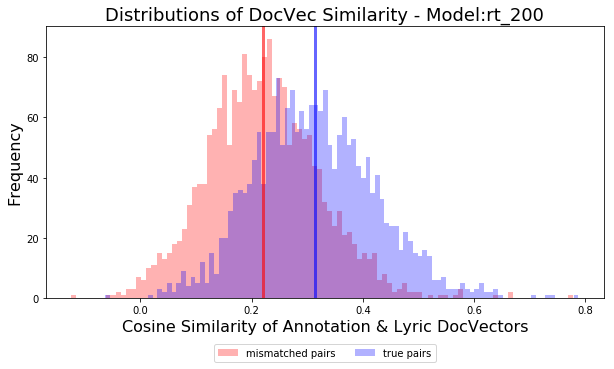

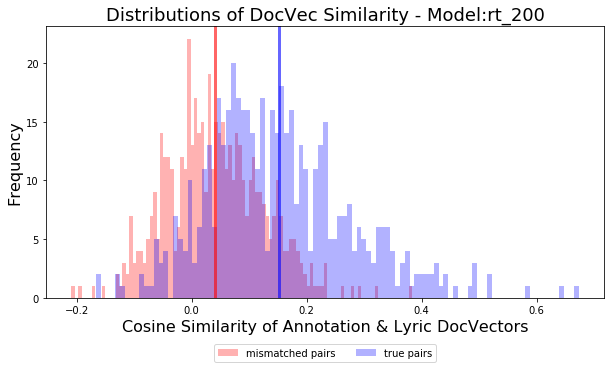

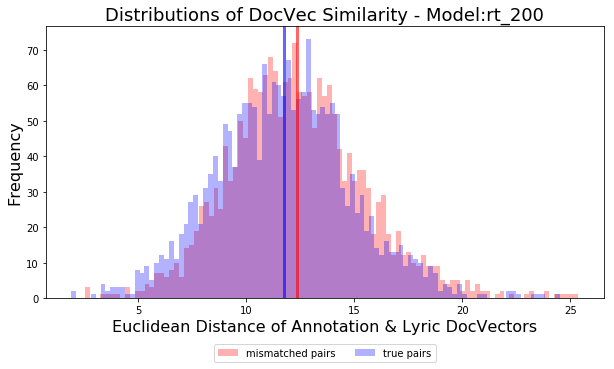

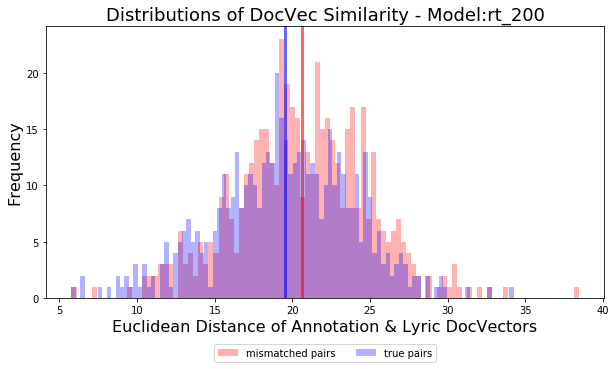

Model training complete!


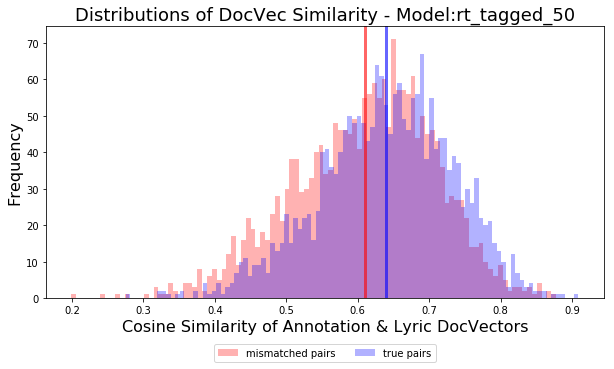

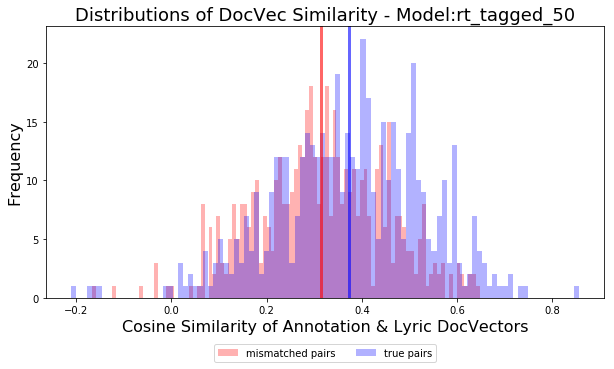

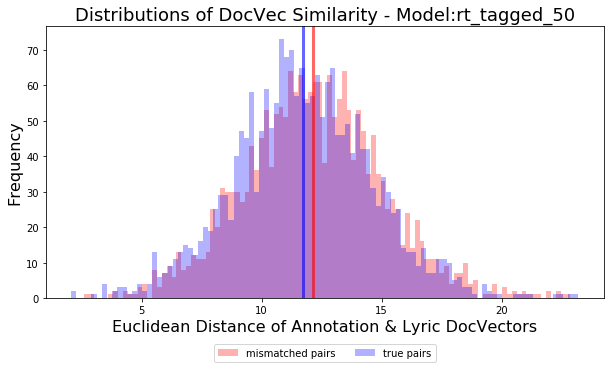

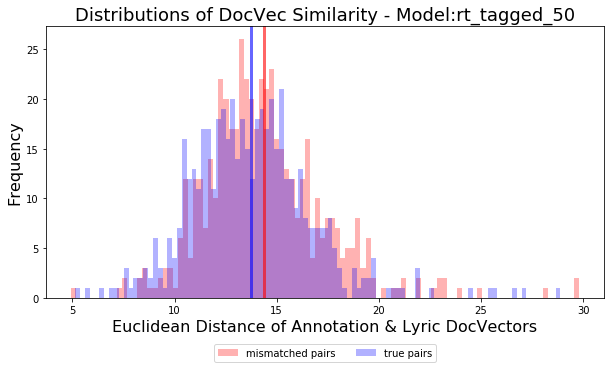

Model training complete!


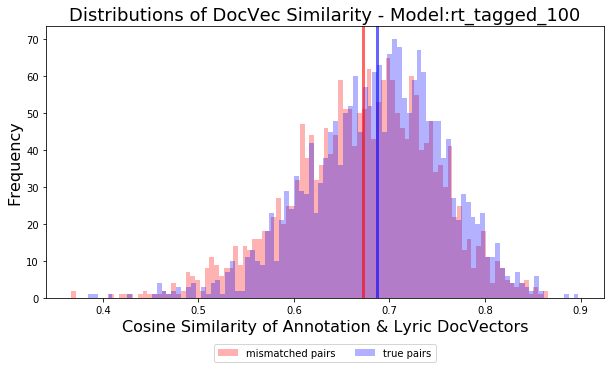

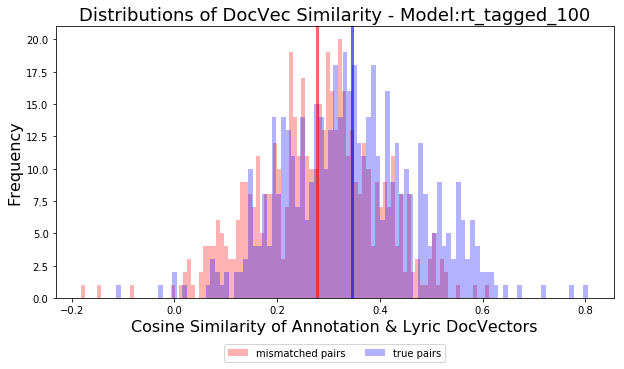

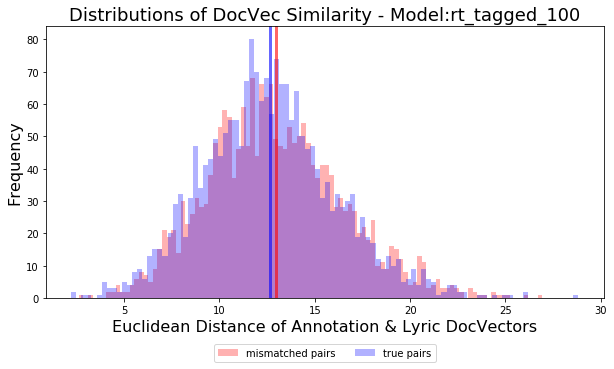

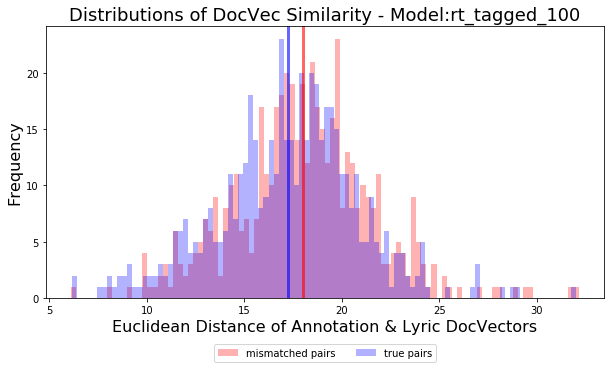

Model training complete!


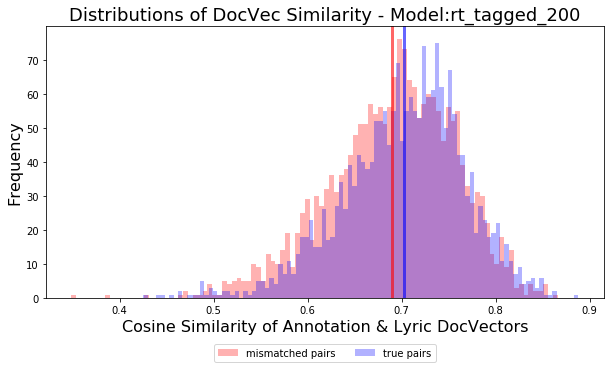

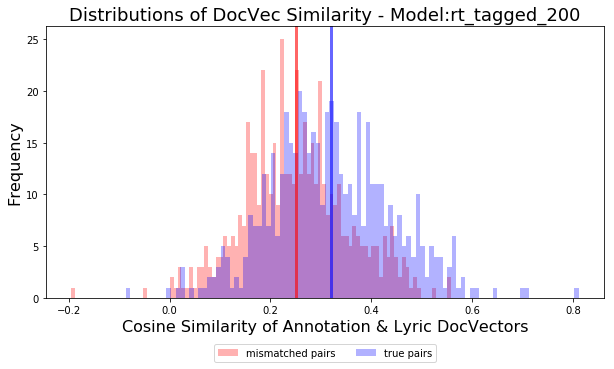

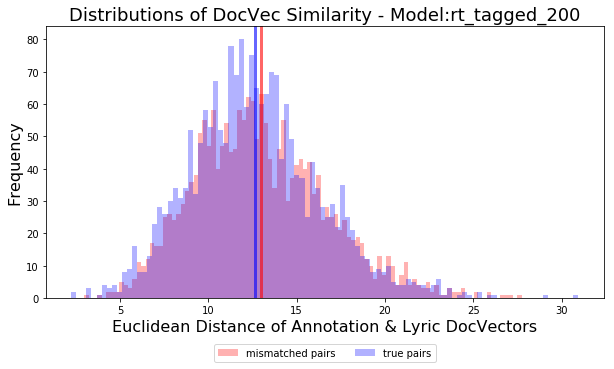

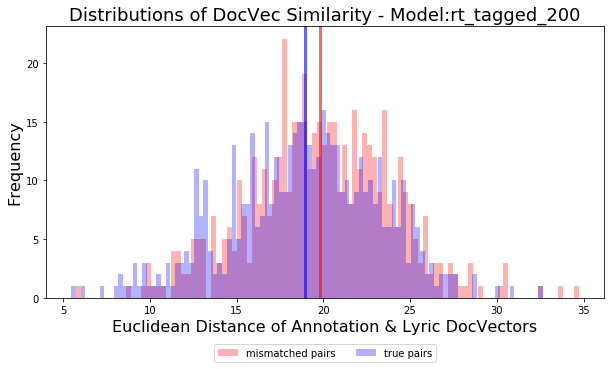

                                                          model  \
r_100          <__main__.Doc2VecModeler object at 0x1a27559668>   
r_200          <__main__.Doc2VecModeler object at 0x1a2748ffd0>   
r_50           <__main__.Doc2VecModeler object at 0x1a275594a8>   
rt_100         <__main__.Doc2VecModeler object at 0x1a2d07ed30>   
rt_200         <__main__.Doc2VecModeler object at 0x1a3031a7f0>   
rt_50          <__main__.Doc2VecModeler object at 0x1a2e2e03c8>   
rt_tagged_100  <__main__.Doc2VecModeler object at 0x1a335dbcc0>   
rt_tagged_200  <__main__.Doc2VecModeler object at 0x1a3382a2b0>   
rt_tagged_50   <__main__.Doc2VecModeler object at 0x1a30c917b8>   
t_100          <__main__.Doc2VecModeler object at 0x1a2e32aac8>   
t_200          <__main__.Doc2VecModeler object at 0x1a2e32ae10>   
t_50           <__main__.Doc2VecModeler object at 0x1a2c212f28>   

               self_recog_rate  cs_train_p_val  cs_test_p_val  ed_train_p_val  \
r_100                 0.977865   6.957850e-159 

In [6]:
doc_eval = DocVecModelEvaluator()

doc_eval.train_new_model('r_50', ref_train_pcorpus, 'r_tr', vector_size=50)
doc_eval.train_new_model('r_100', ref_train_pcorpus, 'r_tr', vector_size=100)
doc_eval.train_new_model('r_200', ref_train_pcorpus, 'r_tr', vector_size=200)

doc_eval.train_new_model('t_50', tate_train_pcorpus, 't_tr', vector_size=50)
doc_eval.train_new_model('t_100', tate_train_pcorpus, 't_tr', vector_size=100)
doc_eval.train_new_model('t_200', tate_train_pcorpus, 't_tr', vector_size=200)

doc_eval.train_new_model('rt_50', rt_train_pcorpus, 'rt_tr', vector_size=50)
doc_eval.train_new_model('rt_100', rt_train_pcorpus, 'rt_tr', vector_size=100)
doc_eval.train_new_model('rt_200', rt_train_pcorpus, 'rt_tr', vector_size=200)

doc_eval.train_new_model('rt_tagged_50', rt_tagged_train_pcorpus, 'rt_tagged_tr', vector_size=50)
doc_eval.train_new_model('rt_tagged_100', rt_tagged_train_pcorpus, 'rt_tagged_tr', vector_size=100)
doc_eval.train_new_model('rt_tagged_200', rt_tagged_train_pcorpus, 'rt_tagged_tr', vector_size=200)

eval_df = doc_eval.print_model_eval_stats()

In [14]:
eval_df

,model,self_recog_rate,cs_train_p_val,cs_test_p_val,ed_train_p_val,ed_test_p_val,cs_is_train_significant,cs_is_test_significant,ed_is_train_significant,ed_is_test_significant,tr_cs_pairings_stats,tst_cs_pairings_stats,tr_ed_pairings_stats,tst_ed_pairings_stats,tr_cs_true_mean,tr_cs_false_mean,tst_cs_true_mean,tst_cs_false_mean,tr_ed_true_mean,tr_ed_false_mean,tst_ed_true_mean,tst_ed_false_mean
r_100,<__main__.Doc2VecModeler object at 0x1a27559668>,0.977865,6.957850e-159,6.514121e-28,3.450611e-08,1.629451e-03,True,True,True,True,0,0,0,0,0.114182,0.010359,0.120732,0.024595,14.052132,14.601185,14.912682,15.625575
r_200,<__main__.Doc2VecModeler object at 0x1a2748ffd0>,0.972946,7.536429e-160,1.023635e-28,7.832393e-08,3.084939e-03,True,True,True,True,0,0,0,0,0.113530,0.010607,0.121226,0.027096,14.157347,14.701354,15.055009,15.744463
r_50,<__main__.Doc2VecModeler object at 0x1a275594a8>,0.974914,7.628259e-133,4.414596e-22,6.354292e-13,8.573157e-04,True,True,True,True,0,0,0,0,0.126047,0.013704,0.126126,0.028782,12.225910,12.799842,12.980481,13.617312
rt_100,<__main__.Doc2VecModeler object at 0x1a2d07ed30>,0.990900,3.941376e-172,1.667962e-42,2.251782e-14,6.731995e-06,True,True,True,True,0,0,0,0,0.314491,0.209675,0.161687,0.048708,11.844452,12.564064,17.235847,18.272081
rt_200,<__main__.Doc2VecModeler object at 0x1a3031a7f0>,0.989179,1.206799e-158,2.757644e-54,1.254827e-10,6.806333e-05,True,True,True,True,0,0,0,0,0.313168,0.221073,0.152141,0.041047,11.735929,12.366209,19.503846,20.610129
rt_50,<__main__.Doc2VecModeler object at 0x1a2e2e03c8>,0.992622,2.214327e-189,2.887634e-30,7.755589e-24,2.902646e-06,True,True,True,True,0,0,0,0,0.328288,0.196979,0.181600,0.066319,11.094254,11.944943,13.290352,14.168888
rt_tagged_100,<__main__.Doc2VecModeler object at 0x1a335dbcc0>,0.010330,1.455854e-10,2.360632e-17,3.292836e-03,3.956872e-04,True,True,True,True,0,0,0,0,0.687205,0.672559,0.344769,0.277462,12.626013,12.952481,17.216447,18.025227
rt_tagged_200,<__main__.Doc2VecModeler object at 0x1a3382a2b0>,0.008116,4.918082e-09,2.430674e-21,9.715426e-03,9.740166e-04,True,True,True,True,0,0,0,0,0.702529,0.690320,0.319402,0.250184,12.662674,12.966533,18.927413,19.813188
rt_tagged_50,<__main__.Doc2VecModeler object at 0x1a30c917b8>,0.036399,1.697466e-23,2.828447e-10,2.807733e-06,8.130214e-04,True,True,True,True,0,0,0,0,0.639899,0.609648,0.373083,0.314147,11.731853,12.156581,13.760196,14.395935
t_100,<__main__.Doc2VecModeler object at 0x1a2e32aac8>,0.997541,1.235010e-178,9.768787e-39,2.200330e-19,5.794483e-06,True,True,True,True,0,0,0,0,0.281516,0.158403,0.177667,0.069946,13.401507,14.448985,17.192370,18.266472


In [15]:
eval_df['train_txt'] = [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
eval_df.drop(['tr_cs_pairings_stats', 'tst_cs_pairings_stats', 'tr_ed_pairings_stats', 'tst_ed_pairings_stats'], axis=1, inplace=True)

In [16]:
eval_df

,model,self_recog_rate,cs_train_p_val,cs_test_p_val,ed_train_p_val,ed_test_p_val,cs_is_train_significant,cs_is_test_significant,ed_is_train_significant,ed_is_test_significant,tr_cs_true_mean,tr_cs_false_mean,tst_cs_true_mean,tst_cs_false_mean,tr_ed_true_mean,tr_ed_false_mean,tst_ed_true_mean,tst_ed_false_mean,train_txt
r_100,<__main__.Doc2VecModeler object at 0x1a27559668>,0.977865,6.957850e-159,6.514121e-28,3.450611e-08,1.629451e-03,True,True,True,True,0.114182,0.010359,0.120732,0.024595,14.052132,14.601185,14.912682,15.625575,0
r_200,<__main__.Doc2VecModeler object at 0x1a2748ffd0>,0.972946,7.536429e-160,1.023635e-28,7.832393e-08,3.084939e-03,True,True,True,True,0.113530,0.010607,0.121226,0.027096,14.157347,14.701354,15.055009,15.744463,0
r_50,<__main__.Doc2VecModeler object at 0x1a275594a8>,0.974914,7.628259e-133,4.414596e-22,6.354292e-13,8.573157e-04,True,True,True,True,0.126047,0.013704,0.126126,0.028782,12.225910,12.799842,12.980481,13.617312,0
rt_100,<__main__.Doc2VecModeler object at 0x1a2d07ed30>,0.990900,3.941376e-172,1.667962e-42,2.251782e-14,6.731995e-06,True,True,True,True,0.314491,0.209675,0.161687,0.048708,11.844452,12.564064,17.235847,18.272081,1
rt_200,<__main__.Doc2VecModeler object at 0x1a3031a7f0>,0.989179,1.206799e-158,2.757644e-54,1.254827e-10,6.806333e-05,True,True,True,True,0.313168,0.221073,0.152141,0.041047,11.735929,12.366209,19.503846,20.610129,1
rt_50,<__main__.Doc2VecModeler object at 0x1a2e2e03c8>,0.992622,2.214327e-189,2.887634e-30,7.755589e-24,2.902646e-06,True,True,True,True,0.328288,0.196979,0.181600,0.066319,11.094254,11.944943,13.290352,14.168888,1
rt_tagged_100,<__main__.Doc2VecModeler object at 0x1a335dbcc0>,0.010330,1.455854e-10,2.360632e-17,3.292836e-03,3.956872e-04,True,True,True,True,0.687205,0.672559,0.344769,0.277462,12.626013,12.952481,17.216447,18.025227,2
rt_tagged_200,<__main__.Doc2VecModeler object at 0x1a3382a2b0>,0.008116,4.918082e-09,2.430674e-21,9.715426e-03,9.740166e-04,True,True,True,True,0.702529,0.690320,0.319402,0.250184,12.662674,12.966533,18.927413,19.813188,2
rt_tagged_50,<__main__.Doc2VecModeler object at 0x1a30c917b8>,0.036399,1.697466e-23,2.828447e-10,2.807733e-06,8.130214e-04,True,True,True,True,0.639899,0.609648,0.373083,0.314147,11.731853,12.156581,13.760196,14.395935,2
t_100,<__main__.Doc2VecModeler object at 0x1a2e32aac8>,0.997541,1.235010e-178,9.768787e-39,2.200330e-19,5.794483e-06,True,True,True,True,0.281516,0.158403,0.177667,0.069946,13.401507,14.448985,17.192370,18.266472,3


In [17]:
eval_df['cs_true_mean_tt_diff'] = eval_df['tr_cs_true_mean'] - eval_df['tst_cs_true_mean']
eval_df['cs_false_mean_tt_diff'] = eval_df['tr_cs_false_mean'] - eval_df['tst_cs_false_mean']
eval_df['ed_true_mean_tt_diff'] = eval_df['tr_ed_true_mean'] - eval_df['tst_ed_true_mean']
eval_df['ed_false_mean_tt_diff'] = eval_df['tr_ed_false_mean'] - eval_df['tst_ed_false_mean']

eval_df

,model,self_recog_rate,cs_train_p_val,cs_test_p_val,ed_train_p_val,ed_test_p_val,cs_is_train_significant,cs_is_test_significant,ed_is_train_significant,ed_is_test_significant,tr_cs_true_mean,tr_cs_false_mean,tst_cs_true_mean,tst_cs_false_mean,tr_ed_true_mean,tr_ed_false_mean,tst_ed_true_mean,tst_ed_false_mean,train_txt,cs_true_mean_tt_diff,cs_false_mean_tt_diff,ed_true_mean_tt_diff,ed_false_mean_tt_diff
r_100,<__main__.Doc2VecModeler object at 0x1a27559668>,0.977865,6.957850e-159,6.514121e-28,3.450611e-08,1.629451e-03,True,True,True,True,0.114182,0.010359,0.120732,0.024595,14.052132,14.601185,14.912682,15.625575,0,-0.006549,-0.014237,-0.860550,-1.024390
r_200,<__main__.Doc2VecModeler object at 0x1a2748ffd0>,0.972946,7.536429e-160,1.023635e-28,7.832393e-08,3.084939e-03,True,True,True,True,0.113530,0.010607,0.121226,0.027096,14.157347,14.701354,15.055009,15.744463,0,-0.007696,-0.016488,-0.897661,-1.043109
r_50,<__main__.Doc2VecModeler object at 0x1a275594a8>,0.974914,7.628259e-133,4.414596e-22,6.354292e-13,8.573157e-04,True,True,True,True,0.126047,0.013704,0.126126,0.028782,12.225910,12.799842,12.980481,13.617312,0,-0.000079,-0.015078,-0.754570,-0.817470
rt_100,<__main__.Doc2VecModeler object at 0x1a2d07ed30>,0.990900,3.941376e-172,1.667962e-42,2.251782e-14,6.731995e-06,True,True,True,True,0.314491,0.209675,0.161687,0.048708,11.844452,12.564064,17.235847,18.272081,1,0.152804,0.160967,-5.391394,-5.708017
rt_200,<__main__.Doc2VecModeler object at 0x1a3031a7f0>,0.989179,1.206799e-158,2.757644e-54,1.254827e-10,6.806333e-05,True,True,True,True,0.313168,0.221073,0.152141,0.041047,11.735929,12.366209,19.503846,20.610129,1,0.161027,0.180027,-7.767918,-8.243921
rt_50,<__main__.Doc2VecModeler object at 0x1a2e2e03c8>,0.992622,2.214327e-189,2.887634e-30,7.755589e-24,2.902646e-06,True,True,True,True,0.328288,0.196979,0.181600,0.066319,11.094254,11.944943,13.290352,14.168888,1,0.146688,0.130660,-2.196098,-2.223944
rt_tagged_100,<__main__.Doc2VecModeler object at 0x1a335dbcc0>,0.010330,1.455854e-10,2.360632e-17,3.292836e-03,3.956872e-04,True,True,True,True,0.687205,0.672559,0.344769,0.277462,12.626013,12.952481,17.216447,18.025227,2,0.342436,0.395097,-4.590433,-5.072747
rt_tagged_200,<__main__.Doc2VecModeler object at 0x1a3382a2b0>,0.008116,4.918082e-09,2.430674e-21,9.715426e-03,9.740166e-04,True,True,True,True,0.702529,0.690320,0.319402,0.250184,12.662674,12.966533,18.927413,19.813188,2,0.383127,0.440136,-6.264740,-6.846656
rt_tagged_50,<__main__.Doc2VecModeler object at 0x1a30c917b8>,0.036399,1.697466e-23,2.828447e-10,2.807733e-06,8.130214e-04,True,True,True,True,0.639899,0.609648,0.373083,0.314147,11.731853,12.156581,13.760196,14.395935,2,0.266816,0.295501,-2.028343,-2.239354
t_100,<__main__.Doc2VecModeler object at 0x1a2e32aac8>,0.997541,1.235010e-178,9.768787e-39,2.200330e-19,5.794483e-06,True,True,True,True,0.281516,0.158403,0.177667,0.069946,13.401507,14.448985,17.192370,18.266472,3,0.103849,0.088457,-3.790863,-3.817487


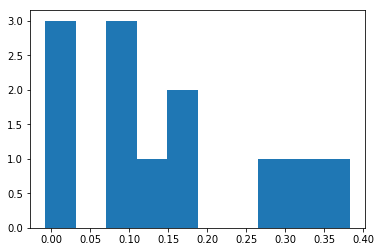

In [18]:
plt.hist(eval_df['cs_true_mean_tt_diff'])
plt.show()

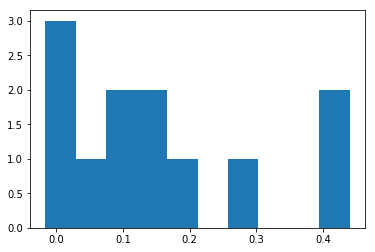

In [19]:
plt.hist(eval_df['cs_false_mean_tt_diff'])
plt.show()

In [20]:
print(eval_df['cs_true_mean_tt_diff'].max())
print(eval_df['cs_true_mean_tt_diff'].min())
print(eval_df['cs_false_mean_tt_diff'].max())
print(eval_df['cs_false_mean_tt_diff'].min())

0.3831271468163977
-0.007696180053833296
0.4401357539799137
-0.016488151409525812


In [21]:
true_most_overfit = eval_df['cs_true_mean_tt_diff'] == eval_df['cs_true_mean_tt_diff'].max()
true_least_overfit = eval_df['cs_true_mean_tt_diff'] == eval_df['cs_true_mean_tt_diff'].min()
false_most_overfit = eval_df['cs_false_mean_tt_diff'] == eval_df['cs_false_mean_tt_diff'].max()
false_least_overfit = eval_df['cs_false_mean_tt_diff'] == eval_df['cs_false_mean_tt_diff'].min()

In [22]:
eval_df[true_most_overfit]

,model,self_recog_rate,cs_train_p_val,cs_test_p_val,ed_train_p_val,ed_test_p_val,cs_is_train_significant,cs_is_test_significant,ed_is_train_significant,ed_is_test_significant,tr_cs_true_mean,tr_cs_false_mean,tst_cs_true_mean,tst_cs_false_mean,tr_ed_true_mean,tr_ed_false_mean,tst_ed_true_mean,tst_ed_false_mean,train_txt,cs_true_mean_tt_diff,cs_false_mean_tt_diff,ed_true_mean_tt_diff,ed_false_mean_tt_diff
rt_tagged_200,<__main__.Doc2VecModeler object at 0x1a3382a2b0>,0.008116,4.918082e-09,2.430674e-21,0.009715,0.000974,True,True,True,True,0.702529,0.69032,0.319402,0.250184,12.662674,12.966533,18.927413,19.813188,2,0.383127,0.440136,-6.26474,-6.846656


In [23]:
eval_df[true_least_overfit]

,model,self_recog_rate,cs_train_p_val,cs_test_p_val,ed_train_p_val,ed_test_p_val,cs_is_train_significant,cs_is_test_significant,ed_is_train_significant,ed_is_test_significant,tr_cs_true_mean,tr_cs_false_mean,tst_cs_true_mean,tst_cs_false_mean,tr_ed_true_mean,tr_ed_false_mean,tst_ed_true_mean,tst_ed_false_mean,train_txt,cs_true_mean_tt_diff,cs_false_mean_tt_diff,ed_true_mean_tt_diff,ed_false_mean_tt_diff
r_200,<__main__.Doc2VecModeler object at 0x1a2748ffd0>,0.972946,7.536429e-160,1.023635e-28,7.832393e-08,0.003085,True,True,True,True,0.11353,0.010607,0.121226,0.027096,14.157347,14.701354,15.055009,15.744463,0,-0.007696,-0.016488,-0.897661,-1.043109


In [24]:
eval_df[false_most_overfit]

,model,self_recog_rate,cs_train_p_val,cs_test_p_val,ed_train_p_val,ed_test_p_val,cs_is_train_significant,cs_is_test_significant,ed_is_train_significant,ed_is_test_significant,tr_cs_true_mean,tr_cs_false_mean,tst_cs_true_mean,tst_cs_false_mean,tr_ed_true_mean,tr_ed_false_mean,tst_ed_true_mean,tst_ed_false_mean,train_txt,cs_true_mean_tt_diff,cs_false_mean_tt_diff,ed_true_mean_tt_diff,ed_false_mean_tt_diff
rt_tagged_200,<__main__.Doc2VecModeler object at 0x1a3382a2b0>,0.008116,4.918082e-09,2.430674e-21,0.009715,0.000974,True,True,True,True,0.702529,0.69032,0.319402,0.250184,12.662674,12.966533,18.927413,19.813188,2,0.383127,0.440136,-6.26474,-6.846656


In [25]:
eval_df[false_least_overfit]

,model,self_recog_rate,cs_train_p_val,cs_test_p_val,ed_train_p_val,ed_test_p_val,cs_is_train_significant,cs_is_test_significant,ed_is_train_significant,ed_is_test_significant,tr_cs_true_mean,tr_cs_false_mean,tst_cs_true_mean,tst_cs_false_mean,tr_ed_true_mean,tr_ed_false_mean,tst_ed_true_mean,tst_ed_false_mean,train_txt,cs_true_mean_tt_diff,cs_false_mean_tt_diff,ed_true_mean_tt_diff,ed_false_mean_tt_diff
r_200,<__main__.Doc2VecModeler object at 0x1a2748ffd0>,0.972946,7.536429e-160,1.023635e-28,7.832393e-08,0.003085,True,True,True,True,0.11353,0.010607,0.121226,0.027096,14.157347,14.701354,15.055009,15.744463,0,-0.007696,-0.016488,-0.897661,-1.043109


### LEAST OVERFIT:
* R_50 (true)
* R_200 (false)

### MOST OVERFIT:
* RT_tagged_200 (BOTH true and false)



In [26]:
eval_df[eval_df['train_txt'] == 1]

,model,self_recog_rate,cs_train_p_val,cs_test_p_val,ed_train_p_val,ed_test_p_val,cs_is_train_significant,cs_is_test_significant,ed_is_train_significant,ed_is_test_significant,tr_cs_true_mean,tr_cs_false_mean,tst_cs_true_mean,tst_cs_false_mean,tr_ed_true_mean,tr_ed_false_mean,tst_ed_true_mean,tst_ed_false_mean,train_txt,cs_true_mean_tt_diff,cs_false_mean_tt_diff,ed_true_mean_tt_diff,ed_false_mean_tt_diff
rt_100,<__main__.Doc2VecModeler object at 0x1a2d07ed30>,0.990900,3.941376e-172,1.667962e-42,2.251782e-14,0.000007,True,True,True,True,0.314491,0.209675,0.161687,0.048708,11.844452,12.564064,17.235847,18.272081,1,0.152804,0.160967,-5.391394,-5.708017
rt_200,<__main__.Doc2VecModeler object at 0x1a3031a7f0>,0.989179,1.206799e-158,2.757644e-54,1.254827e-10,0.000068,True,True,True,True,0.313168,0.221073,0.152141,0.041047,11.735929,12.366209,19.503846,20.610129,1,0.161027,0.180027,-7.767918,-8.243921
rt_50,<__main__.Doc2VecModeler object at 0x1a2e2e03c8>,0.992622,2.214327e-189,2.887634e-30,7.755589e-24,0.000003,True,True,True,True,0.328288,0.196979,0.181600,0.066319,11.094254,11.944943,13.290352,14.168888,1,0.146688,0.130660,-2.196098,-2.223944


In [27]:
eval_df[eval_df['train_txt'] == 1]

,model,self_recog_rate,cs_train_p_val,cs_test_p_val,ed_train_p_val,ed_test_p_val,cs_is_train_significant,cs_is_test_significant,ed_is_train_significant,ed_is_test_significant,tr_cs_true_mean,tr_cs_false_mean,tst_cs_true_mean,tst_cs_false_mean,tr_ed_true_mean,tr_ed_false_mean,tst_ed_true_mean,tst_ed_false_mean,train_txt,cs_true_mean_tt_diff,cs_false_mean_tt_diff,ed_true_mean_tt_diff,ed_false_mean_tt_diff
rt_100,<__main__.Doc2VecModeler object at 0x1a2d07ed30>,0.990900,3.941376e-172,1.667962e-42,2.251782e-14,0.000007,True,True,True,True,0.314491,0.209675,0.161687,0.048708,11.844452,12.564064,17.235847,18.272081,1,0.152804,0.160967,-5.391394,-5.708017
rt_200,<__main__.Doc2VecModeler object at 0x1a3031a7f0>,0.989179,1.206799e-158,2.757644e-54,1.254827e-10,0.000068,True,True,True,True,0.313168,0.221073,0.152141,0.041047,11.735929,12.366209,19.503846,20.610129,1,0.161027,0.180027,-7.767918,-8.243921
rt_50,<__main__.Doc2VecModeler object at 0x1a2e2e03c8>,0.992622,2.214327e-189,2.887634e-30,7.755589e-24,0.000003,True,True,True,True,0.328288,0.196979,0.181600,0.066319,11.094254,11.944943,13.290352,14.168888,1,0.146688,0.130660,-2.196098,-2.223944


In [28]:
eval_df.to_csv('../data/eval_df_i.csv')

In [29]:
eval_df['tr_cs_true_mean'][9:12]

t_100    0.281516
t_200    0.270560
t_50     0.309800
Name: tr_cs_true_mean, dtype: float64

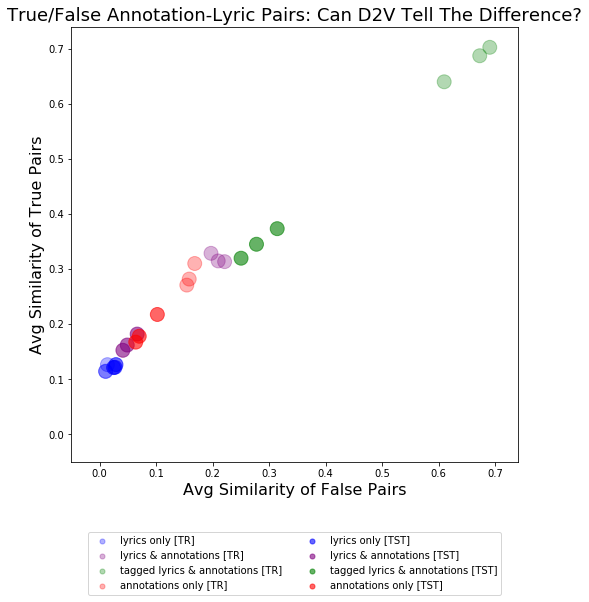

In [31]:
x_tr0 = eval_df['tr_cs_false_mean'][:3]
y_tr0 = eval_df['tr_cs_true_mean'][:3]
x_tr1 = eval_df['tr_cs_false_mean'][3:6]
y_tr1 = eval_df['tr_cs_true_mean'][3:6]
x_tr2 = eval_df['tr_cs_false_mean'][6:9]
y_tr2 = eval_df['tr_cs_true_mean'][6:9]
x_tr3 = eval_df['tr_cs_false_mean'][9:12]
y_tr3 = eval_df['tr_cs_true_mean'][9:12]

x_tst0 = eval_df['tst_cs_false_mean'][:3]
y_tst0 = eval_df['tst_cs_true_mean'][:3]
x_tst1 = eval_df['tst_cs_false_mean'][3:6]
y_tst1 = eval_df['tst_cs_true_mean'][3:6]
x_tst2 = eval_df['tst_cs_false_mean'][6:9]
y_tst2 = eval_df['tst_cs_true_mean'][6:9]
x_tst3 = eval_df['tst_cs_false_mean'][9:12]
y_tst3 = eval_df['tst_cs_true_mean'][9:12]

size = eval_df['self_recog_rate']*200
colors = eval_df['train_txt']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title("True/False Annotation-Lyric Pairs: Can D2V Tell The Difference?", fontsize=18)

# ax.scatter(x, y, s=size, alpha=0.4, c=colors)
ax.scatter(x_tr0, y_tr0, s=size, alpha=0.3, c='blue', label='lyrics only [TR]')
ax.scatter(x_tr1, y_tr1, s=size, alpha=0.3, c='purple', label='lyrics & annotations [TR]')
ax.scatter(x_tr2, y_tr2, s=size, alpha=0.3, c='green', label='tagged lyrics & annotations [TR]')
ax.scatter(x_tr3, y_tr3, s=size, alpha=0.3, c='red', label='annotations only [TR]')

ax.scatter(x_tst0, y_tst0, s=size, alpha=0.6, c='blue', label='lyrics only [TST]')
ax.scatter(x_tst1, y_tst1, s=size, alpha=0.6, c='purple', label='lyrics & annotations [TST]')
ax.scatter(x_tst2, y_tst2, s=size, alpha=0.6, c='green', label='tagged lyrics & annotations [TST]')
ax.scatter(x_tst3, y_tst3, s=size, alpha=0.6, c='red', label='annotations only [TST]')

# plt.plot(x, x + .075, ':r', label = "est. line of best fit");  # dotted red

# ax.scatter(0, 0.75, s=200, alpha=0.9, c='yellow', label='target_similarity')

plt.xlim(-0.05, 0.74)
plt.ylim(-0.05, 0.74);

# plt.axvline(x=train_true_ed.mean(), c='blue', alpha=0.3)
# plt.axvline(x=train_false_ed.mean(), c='red', alpha=0.3)
# plt.axhline(y=train_true_cs.mean(), c='blue', alpha=0.3)
# plt.axhline(y=train_false_cs.mean(), c='red', alpha=0.3)

ax.set_xlabel('Avg Similarity of False Pairs', fontsize=16)
ax.set_ylabel('Avg Similarity of True Pairs', fontsize=16)
ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

fig.savefig('tr_tst_true_false_mean_cs.png')

**What does this mean?**

Thinking: The further test is from train, the more the model is overfit...

Lyrics only - least overfit
Tagged L&A - very overfit

Kinda a linear trend... Interesting. 

roughly: y = 1*x + 0.05

Thinking: Lyrics & Annotations are best -- might increase slightly more??

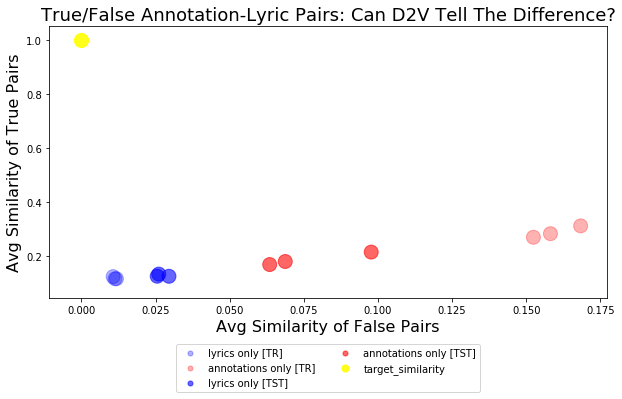

In [31]:
x_tr0 = eval_df['tr_cs_false_mean'][:3]
y_tr0 = eval_df['tr_cs_true_mean'][:3]
x_tr1 = eval_df['tr_cs_false_mean'][3:6]
y_tr1 = eval_df['tr_cs_true_mean'][3:6]
x_tr2 = eval_df['tr_cs_false_mean'][6:9]
y_tr2 = eval_df['tr_cs_true_mean'][6:9]
x_tr3 = eval_df['tr_cs_false_mean'][9:12]
y_tr3 = eval_df['tr_cs_true_mean'][9:12]

x_tst0 = eval_df['tst_cs_false_mean'][:3]
y_tst0 = eval_df['tst_cs_true_mean'][:3]
x_tst1 = eval_df['tst_cs_false_mean'][3:6]
y_tst1 = eval_df['tst_cs_true_mean'][3:6]
x_tst2 = eval_df['tst_cs_false_mean'][6:9]
y_tst2 = eval_df['tst_cs_true_mean'][6:9]
x_tst3 = eval_df['tst_cs_false_mean'][9:12]
y_tst3 = eval_df['tst_cs_true_mean'][9:12]

size = eval_df['self_recog_rate']*200
colors = eval_df['train_txt']

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title("True/False Annotation-Lyric Pairs: Can D2V Tell The Difference?", fontsize=18)

# ax.scatter(x, y, s=size, alpha=0.4, c=colors)
ax.scatter(x_tr0, y_tr0, s=size, alpha=0.3, c='blue', label='lyrics only [TR]')
# ax.scatter(x_tr1, y_tr1, s=size, alpha=0.3, c='purple', label='lyrics & annotations [TR]')
# ax.scatter(x_tr2, y_tr2, s=size, alpha=0.3, c='green', label='tagged lyrics & annotations [TR]')
ax.scatter(x_tr3, y_tr3, s=size, alpha=0.3, c='red', label='annotations only [TR]')

ax.scatter(x_tst0, y_tst0, s=size, alpha=0.6, c='blue', label='lyrics only [TST]')
# ax.scatter(x_tst1, y_tst1, s=size, alpha=0.6, c='purple', label='lyrics & annotations [TST]')
# ax.scatter(x_tst2, y_tst2, s=size, alpha=0.6, c='green', label='tagged lyrics & annotations [TST]')
ax.scatter(x_tst3, y_tst3, s=size, alpha=0.6, c='red', label='annotations only [TST]')


ax.scatter(0, 1, s=200, alpha=0.9, c='yellow', label='target_similarity')

# plt.axvline(x=train_true_ed.mean(), c='blue', alpha=0.3)
# plt.axvline(x=train_false_ed.mean(), c='red', alpha=0.3)
# plt.axhline(y=train_true_cs.mean(), c='blue', alpha=0.3)
# plt.axhline(y=train_false_cs.mean(), c='red', alpha=0.3)

ax.set_xlabel('Avg Similarity of False Pairs', fontsize=16)
ax.set_ylabel('Avg Similarity of True Pairs', fontsize=16)
ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()


In [32]:
from sklearn.manifold import TSNE

In [262]:
save_in_pkl(eval_df, 'eval_df_i')

In [33]:
rt_50 = eval_df[eval_df.index == 'rt_50']['model'][0]

In [80]:
# alright, let's pick some examples... Go w/ Kendrick? Kanye? vs. that eminem one? try to pick short&sweet ones...
holdout_df = pd.read_csv('../data/genius_holdout_data.csv')
holdout_df.head()

,Unnamed: 0,Unnamed: 0.1,ref_text,tate_text,votes_total,verified,state,song_id,song_title,full_title,song_tate_cnt,pageviews,n_unreviewed_tates,full_lyrics,url,n_tate_contributors,primary_contributor_id,primary_contributor_IQ,has_voters,comment_cnt,artist_name,artist_id,rt_id,votes_per_1000views,chars_in_tate,chars_in_referent,ref_word_lst,tate_word_lst,ref_word_cnt,tate_word_cnt
0,1027,1235,My only regret was too young for Lisa Bonet,Cole regrets engaging in these superficial rel...,42,True,verified,599427,No Role Modelz,No Role Modelz by J. Cole,34,4070098,0,['First things first: rest in peace Uncle Phil...,https://genius.com/4967422/J-cole-no-role-mode...,1,1557450,182,True,0,J. Cole,69,4967422,1.03,366,43,"['my', 'only', 'regret', 'was', 'too', 'young'...","['cole', 'regrets', 'engaging', 'in', 'these',...",9,65
1,1503,1798,"Sun don't shine in the shade, ugh","All Kanye ever wanted to do was shine, but aft...",50,False,accepted,2412668,Waves,Waves by Kanye West (Ft. Chris Brown),12,1496063,0,"['Turn me up!', 'Step up in this bitch like (t...",https://genius.com/8672327/Kanye-west-waves/Su...,4,2440225,7201,True,0,Kanye West,72,8672327,3.34,844,33,"['sun', ""don't"", 'shine', 'in', 'the', 'shade,...","['all', 'kanye', 'ever', 'wanted', 'to', 'do',...",7,145
2,785,919,I got way too much on my mental,Similar to what Mac Miller said on Blue Slide ...,11,False,accepted,196551,All Me,All Me by Drake (Ft. 2 Chainz & Big Sean),84,3761542,0,"[""I'm really stepping up my game"", 'These bitc...",https://genius.com/2786526/Drake-all-me/I-got-...,1,177628,27447,True,1,Drake,130,2786526,0.29,223,31,"['i', 'got', 'way', 'too', 'much', 'on', 'my',...","['similar', 'to', 'what', 'mac', 'miller', 'sa...",8,43
3,411,456,"And I, and I love it...\n And I thank you, I t...",He insists that the changes that this girl has...,30,False,accepted,1944,Blame Game,Blame Game by Kanye West (Ft. John Legend),57,1215454,1,"['Whose fault?', ""Let's play the blame game, I...",https://genius.com/1821590/Kanye-west-blame-ga...,1,116340,255161,True,0,Kanye West,72,1821590,2.47,126,134,"['and', 'i,', 'and', 'i', 'love', 'it...', 'an...","['he', 'insists', 'that', 'the', 'changes', 't...",29,27
4,1103,1332,"Nah homie we too sensitive, it spill out to th...",A reference to his verse on Big Sean’s “Contro...,35,False,accepted,722284,Hood Politics,Hood Politics by Kendrick Lamar,41,1101708,0,"['K-Dot, pick up the phone, nigga', ""Every tim...",https://genius.com/5080815/Kendrick-lamar-hood...,2,465645,90783,True,0,Kendrick Lamar,1421,5080815,3.18,887,55,"['nah', 'homie', 'we', 'too', 'sensitive,', 'i...","['a', 'reference', 'to', 'his', 'verse', 'on',...",11,156


In [82]:
holdout_df.sort_values(['votes_per_1000views'])

,Unnamed: 0,Unnamed: 0.1,ref_text,tate_text,votes_total,verified,state,song_id,song_title,full_title,song_tate_cnt,pageviews,n_unreviewed_tates,full_lyrics,url,n_tate_contributors,primary_contributor_id,primary_contributor_IQ,has_voters,comment_cnt,artist_name,artist_id,rt_id,votes_per_1000views,chars_in_tate,chars_in_referent,ref_word_lst,tate_word_lst,ref_word_cnt,tate_word_cnt
366,3031,3424,Soon you’ll,Very soon she will ….,-3,False,pending,2313909,You'll Be Back,You'll Be Back by Original Broadway Cast of Ha...,33,1829937,5,"['You say', 'The price of my love’s not a pric...",https://genius.com/15947795/Original-broadway-...,1,7151793,50,True,1,Original Broadway Cast of Hamilton,572149,15947795,-0.16,21,11,"['soon', 'you’ll']","['very', 'soon', 'she', 'will', '….']",2,5
263,1831,2163,And wash me over until my well runs dry\n Send...,"Continuing the fluid imagery, Bey is being was...",0,False,accepted,299253,Rocket,Rocket by Beyoncé,29,817074,2,"['Let me sit this ass on you, show you how I f...",https://genius.com/10143080/Beyonce-rocket/And...,1,3518228,1223,False,0,Beyoncé,498,10143080,0.00,496,85,"['and', 'wash', 'me', 'over', 'until', 'my', '...","['continuing', 'the', 'fluid', 'imagery,', 'be...",19,83
192,2823,3211,Burr!,"The Burr here, may be a reference to a cut son...",0,False,accepted,2314075,The Election of 1800,The Election of 1800 by Original Broadway Cast...,61,658437,4,"['The election of 1800', 'Can we get back to p...",https://genius.com/15129215/Original-broadway-...,1,6729517,193,False,0,Original Broadway Cast of Hamilton,572149,15129215,0.00,325,5,['burr!'],"['the', 'burr', 'here,', 'may', 'be', 'a', 're...",1,60
274,3171,3574,"Love me like, love",I want to suggest that the way this is cut up ...,0,False,pending,3138628,Family Feud,Family Feud by JAY-Z (Ft. Beyoncé),30,693370,2,"['(Ha-ya) My nigga got on', '(Ha-ya) My nigga ...",https://genius.com/16652099/Jay-z-family-feud/...,1,2119306,619,False,0,JAY-Z,2,16652099,0.00,153,18,"['love', 'me', 'like,', 'love']","['i', 'want', 'to', 'suggest', 'that', 'the', ...",4,32
490,73,76,Ball on automatic start,Double entendre:\n“Ball on” could mean to keep...,0,False,pending,896,Right Above It,Right Above It by Lil Wayne (Ft. Drake),41,684624,2,"['Kane is in the building', 'Who else is reall...",https://genius.com/254647/Lil-wayne-right-abov...,1,8534,298877,True,1,Lil Wayne,4,254647,0.00,267,23,"['ball', 'on', 'automatic', 'start']","['double', 'entendre:', '“ball', 'on”', 'could...",4,49
157,2909,3300,'Cause I told her I was sleep\n 'Cause I creep...,From the previous line (dancehall vibes with m...,0,False,pending,164574,She Knows,She Knows by J. Cole (Ft. Amber Coffman),25,1194043,3,"['She knows', 'She knows, ayy', 'Bad things ha...",https://genius.com/15360778/J-cole-she-knows/C...,1,209284,173,False,0,J. Cole,69,15360778,0.00,304,87,"[""'cause"", 'i', 'told', 'her', 'i', 'was', 'sl...","['from', 'the', 'previous', 'line', '(dancehal...",18,52
249,3167,3570,I should've held you close\n Should've kept yo...,X is upset that he wasn’t good enough to meet ...,0,False,pending,2465721,LET'S PRETEND WE'RE NUMB,LET'S PRETEND WE'RE NUMB by XXXTENTACION,11,473590,4,['As a fair warning to everyone listening to t...,https://genius.com/16620996/Xxxtentacion-lets-...,1,5147438,90,False,0,XXXTENTACION,396565,16620996,0.00,226,51,"['i', ""should've"", 'held', 'you', 'close', ""sh...","['x', 'is', 'upset', 'that', 'he', 'wasn’t', '...",9,42
62,3090,3486,Number three!,"There are 3 duels in the musical, this one wit...",0,False,pending,2314641,Ten Duel Commandments,Ten Duel Commandments by Original Broadway Cas...,36,736831,6,"['One, two, three, four', 'Five, six, seven, e...",https://genius.com/16305483/Original-broadway-...,1,4055383,503,False,0,Original Broadway Cast of Hamilton,572149,16305483,0.00,184,13,"['number', 'three!']","['there', 'are', '3', 'duels', 'in', 'the', 'm...",2,37
458,1001,1205,"Hello 'Mari, how ya doin'?\n I think the storm...",I didn’t know Kanye’s name 

In [83]:
train_df.sort_values(['votes_per_1000views'])

,Unnamed: 0,ref_text,tate_text,votes_total,verified,state,song_id,song_title,full_title,song_tate_cnt,pageviews,n_unreviewed_tates,full_lyrics,url,n_tate_contributors,primary_contributor_id,primary_contributor_IQ,has_voters,comment_cnt,artist_name,artist_id,rt_id,votes_per_1000views,chars_in_tate,chars_in_referent,ref_word_lst,tate_word_lst,ref_word_cnt,tate_word_cnt
636,715,Try to deny it as much as you want\n But in ti...,They can say they don’t love each-other but as...,-9,False,accepted,203953,Almost Is Never Enough,Almost Is Never Enough by Ariana Grande (Ft. N...,6,332156,1,"[""I'd like to say we gave it a try"", ""I'd like...",https://genius.com/2222801/Ariana-grande-almos...,1,187843,203,True,2,Ariana Grande,26507,2222801,-2.71,158,151,"['try', 'to', 'deny', 'it', 'as', 'much', 'as'...","['they', 'can', 'say', 'they', 'don’t', 'love'...",31,30
1040,1252,"Everyday, I was strugglin' to learn what life'...","Although it may sound like andale, it may be “...",-46,True,verified,703734,Legend,Legend by Drake,24,1904625,0,"['Yeah', 'When I pull up on a nigga tell that ...",https://genius.com/5023358/Drake-legend/Everyd...,1,526037,77,True,4,Drake,130,5023358,-2.42,166,105,"['everyday,', 'i', 'was', ""strugglin'"", 'to', ...","['although', 'it', 'may', 'sound', 'like', 'an...",19,33
2533,2913,Hamilton,It bothered me that this wasn’t highlighted li...,-14,False,pending,2315167,Cabinet Battle #2,Cabinet Battle #2 by Original Broadway Cast of...,49,716566,4,['The issue on the table: France is on the ver...,https://genius.com/13660449/Original-broadway-...,1,5868330,90,True,5,Original Broadway Cast of Hamilton,572149,13660449,-1.95,65,8,['hamilton'],"['it', 'bothered', 'me', 'that', 'this', 'wasn...",1,10
984,1181,Order Domino's and she take off all her clothe...,Cole is referring to the fact that Domino’s ha...,-28,True,verified,599424,G.O.M.D.,G.O.M.D. by J. Cole,32,1697792,0,"['Hollywood Cole, go', 'Ay Hollywood, ay Holly...",https://genius.com/4852274/J-cole-gomd/Order-d...,1,763714,75,True,3,J. Cole,69,4852274,-1.65,180,100,"['order', ""domino's"", 'and', 'she', 'take', 'o...","['cole', 'is', 'referring', 'to', 'the', 'fact...",20,34
2058,2412,Dismisses,To dismiss somebody or something implies that ...,-3,False,pending,2314638,Stay Alive,Stay Alive by Original Broadway Cast of Hamilton,52,698540,4,"['Stay alive…', 'Stay alive…', 'I have never s...",https://genius.com/11203615/Original-broadway-...,1,4206554,173,True,0,Original Broadway Cast of Hamilton,572149,11203615,-0.43,354,9,['dismisses'],"['to', 'dismiss', 'somebody', 'or', 'something...",1,57
3103,3500,"I mean, I don't know what y'all came here to d...",“Smoke” means to beef someone. Wayne boasts a ...,-2,False,pending,3985353,Uproar,Uproar by Lil Wayne (Ft. Swizz Beatz),21,654124,4,"['(Weezy, Weezy, Weezy, Weezy', 'Weezy, Weezy,...",https://genius.com/16343598/Lil-wayne-uproar/I...,1,7096221,683,True,1,Lil Wayne,4,16343598,-0.31,213,116,"['i', 'mean,', 'i', ""don't"", 'know', 'what', ""...","['“smoke”', 'means', 'to', 'beef', 'someone.',...",25,37
3109,3507,Maybe we just weren't right\n But that's a lie...,we feel that we weren’t right with our exes bu...,-1,False,pending,203953,Almost Is Never Enough,Almost Is Never Enough by Ariana Grande (Ft. N...,6,332156,1,"[""I'd like to say we gave it a try"", ""I'd like...",https://genius.com/16382952/Ariana-grande-almo...,1,7833591,8,True,0,Ariana Grande,26507,16382952,-0.30,102,59,"['maybe', 'we', 'just', ""weren't"", 'right', 'b...","['we', 'feel', 'that', 'we', 'weren’t', 'right...",12,20
2422,2801,Come back to sleep,Notice the resemblance from “Take a Break” whe...,-1,False,pending,2312666,Best of Wives and Best of Women,Best of Wives and Best of Women by Original Br...,14,351079,1,"['Alexander, come back to sleep', 'I have an e...",https://genius.com/12934208/Original-broadway-...,1,5346023,341,True,3,Original Broadway Cast of Hamilton,572149,12934208,-0.28,255,18,"['come', 'back', 'to', 'sleep']","['notice', 'the', 'res

In [85]:
train_df[train_df['artist_name'] == 'Kendrick Lamar'].sort_values(['votes_per_1000views'])

,Unnamed: 0,ref_text,tate_text,votes_total,verified,state,song_id,song_title,full_title,song_tate_cnt,pageviews,n_unreviewed_tates,full_lyrics,url,n_tate_contributors,primary_contributor_id,primary_contributor_IQ,has_voters,comment_cnt,artist_name,artist_id,rt_id,votes_per_1000views,chars_in_tate,chars_in_referent,ref_word_lst,tate_word_lst,ref_word_cnt,tate_word_cnt
3177,3580,If I'm wrong I don't wanna be right,https://www.youtube.com/watch?v=FvJj7SN9EWI,0,False,pending,69982,The Recipe,The Recipe by Kendrick Lamar (Ft. Dr. Dre),34,1200890,1,"[""Smokin' weed with you"", ""'Cause you taught m...",https://genius.com/16714522/Kendrick-lamar-the...,1,282333,10563,False,0,Kendrick Lamar,1421,16714522,0.00,43,35,"['if', ""i'm"", 'wrong', 'i', ""don't"", 'wanna', ...",['https://www.youtube.com/watch?v=fvjj7sn9ewi'],8,1
3065,3460,May the womb of my mother be blessed for many ...,This ties in with the lines later in this vers...,3,False,pending,90479,"Sing About Me, I'm Dying of Thirst","Sing About Me, I'm Dying of Thirst by Kendrick...",97,2189975,1,"[""When the lights shut off and it's my turn"", ...",https://genius.com/16094003/Kendrick-lamar-sin...,1,871686,1034,True,0,Kendrick Lamar,1421,16094003,0.14,312,51,"['may', 'the', 'womb', 'of', 'my', 'mother', '...","['this', 'ties', 'in', 'with', 'the', 'lines',...",11,55
2412,2791,"I rapped him and made him Casper,","Well, forget the lengthy decomposition of Rigo...",2,False,accepted,51798,Rigamortus,Rigamortus by Kendrick Lamar,33,1295092,0,"['Alright, here we go, third take', 'Real quic...",https://genius.com/12917354/Kendrick-lamar-rig...,1,3251272,87005,True,0,Kendrick Lamar,1421,12917354,0.15,276,33,"['i', 'rapped', 'him', 'and', 'made', 'him', '...","['well,', 'forget', 'the', 'lengthy', 'decompo...",7,41
3000,3392,Record your message after the tone,This is the first of many times we hear a beep...,2,False,pending,90472,Sherane a.k.a Master Splinter's Daughter,Sherane a.k.a Master Splinter's Daughter by Ke...,52,1101596,1,"['Lord God, I come to you a sinner', 'And I hu...",https://genius.com/15731533/Kendrick-lamar-she...,1,6220714,272,True,0,Kendrick Lamar,1421,15731533,0.18,370,34,"['record', 'your', 'message', 'after', 'the', ...","['this', 'is', 'the', 'first', 'of', 'many', '...",6,68
868,1027,"Deal with the outcome, a strap in the hand","Guns, which are incredibly dangerous, are a st...",13,False,accepted,90478,​m.A.A.d city,​m.A.A.d city by Kendrick Lamar (Ft. MC Eiht),89,5931650,0,"['If Pirus and Crips all got along', ""They'd p...",https://genius.com/3439197/Kendrick-lamar-maad...,3,1545969,22762,True,0,Kendrick Lamar,1421,3439197,0.22,209,42,"['deal', 'with', 'the', 'outcome,', 'a', 'stra...","['guns,', 'which', 'are', 'incredibly', 'dange...",9,40
2414,2793,I assassin my casualty\n And it's casually don...,“Casualty” can be defined as a person killed o...,3,False,accepted,51798,Rigamortus,Rigamortus by Kendrick Lamar,33,1295092,0,"['Alright, here we go, third take', 'Real quic...",https://genius.com/12922232/Kendrick-lamar-rig...,1,3251272,87005,True,0,Kendrick Lamar,1421,12922232,0.23,781,132,"['i', 'assassin', 'my', 'casualty', 'and', ""it...","['“casualty”', 'can', 'be', 'defined', 'as', '...",26,120
250,259,"They want that shit, they often fiend\n I give...","People want to hear Kendrick’s music, (his shi...",3,False,accepted,69982,The Recipe,The Recipe by Kendrick Lamar (Ft. Dr. Dre),34,1200890,1,"[""Smokin' weed with you"", ""'Cause you taught m...",https://genius.com/723086/Kendrick-lamar-the-r...,3,148687,36,True,2,Kendrick Lamar,1421,723086,0.25,328,81,"['they', 'want', 'that', 'shit,', 'they', 'oft...","['people', 'want', 'to', 'hear', 'kendrick’s',...",17,61
2341,2714,"I can't even keep the peace, don't you fuck wi...",A common practice promoted by activist groups ...,12,False,accepted,3047142,XXX.,XXX. by Kendrick Lamar (Ft. U2),26,4428467,0,"[""America, God bless you if it's good to you"",...",https://genius.com/12313142/Kendrick-lamar-xxx...,1,1304457,23

In [101]:
train_df[train_df['artist_name'] == 'Eminem'].sort_values(['votes_per_1000views'])

,Unnamed: 0,ref_text,tate_text,votes_total,verified,state,song_id,song_title,full_title,song_tate_cnt,pageviews,n_unreviewed_tates,full_lyrics,url,n_tate_contributors,primary_contributor_id,primary_contributor_IQ,has_voters,comment_cnt,artist_name,artist_id,rt_id,votes_per_1000views,chars_in_tate,chars_in_referent,ref_word_lst,tate_word_lst,ref_word_cnt,tate_word_cnt
1037,1246,"Now, I don't wanna seem indulgent\n When I dis...","Eminem has had highs and lows in his career, f...",-2,True,verified,505111,Guts Over Fear,Guts Over Fear by Eminem (Ft. Sia),48,1000477,0,"[""Feels like a close, it's coming to"", 'Fuck a...",https://genius.com/5016679/Eminem-guts-over-fe...,1,1578817,105,True,0,Eminem,45,5016679,-0.20,466,142,"['now,', 'i', ""don't"", 'wanna', 'seem', 'indul...","['eminem', 'has', 'had', 'highs', 'and', 'lows...",29,93
236,244,"Music is like magic, there's a certain feelin'...",This is likely an interpolation of Rakim’s “Re...,1,False,accepted,440,'Till I Collapse,'Till I Collapse by Eminem (Ft. Nate Dogg),47,1569486,0,"[""'Cause sometimes you just feel tired, feel w...",https://genius.com/682180/Eminem-till-i-collap...,2,2996174,34749,True,0,Eminem,45,682180,0.06,160,116,"['music', 'is', 'like', 'magic,', ""there's"", '...","['this', 'is', 'likely', 'an', 'interpolation'...",22,29
3022,3415,Each nut is the chair width of an Acorn stairl...,Acorn is a company that makes stairlifts: devi...,2,False,accepted,3930564,Kamikaze,Kamikaze by Eminem,31,1903591,0,"['(Fack) Okay, (Fack) how do I say this? (Fack...",https://genius.com/15851828/Eminem-kamikaze/Ea...,1,2664110,3488,True,0,Eminem,45,15851828,0.11,290,63,"['each', 'nut', 'is', 'the', 'chair', 'width',...","['acorn', 'is', 'a', 'company', 'that', 'makes...",13,52
2389,2764,"Let off, then I'm reloadin'\n Immediately with...",To “tote” something is to hold something subst...,16,False,accepted,235729,Rap God,Rap God by Eminem,122,13873324,0,"['""Look, I was gonna go easy on you not to hur...",https://genius.com/12697856/Eminem-rap-god/Let...,1,4826731,10323,True,0,Eminem,45,12697856,0.12,211,69,"['let', 'off,', 'then', ""i'm"", ""reloadin'"", 'i...","['to', '“tote”', 'something', 'is', 'to', 'hol...",11,38
3108,3506,"Man I used to risk it all, now I got too much ...","When Eminem says he used to risk it all, he me...",5,False,pending,3930558,Lucky You,Lucky You by Eminem (Ft. Joyner Lucas),37,3472429,1,"['Whoa, Joyner, Joyner, yeah, yeah, yeah', 'Ye...",https://genius.com/16379776/Eminem-lucky-you/M...,1,317402,168,True,0,Eminem,45,16379776,0.14,714,53,"['man', 'i', 'used', 'to', 'risk', 'it', 'all,...","['when', 'eminem', 'says', 'he', 'used', 'to',...",14,129
3165,3568,"Invisible with the pen, I'm at the pinnacle of...",On this track Eminem perhaps does the biggest ...,3,False,pending,3930563,Not Alike,Not Alike by Eminem (Ft. Royce da 5'9''),34,2195010,1,"['Tay Keith, fuck these niggas up!', 'Yeah', '...",https://genius.com/16614388/Eminem-not-alike/I...,1,7118778,1431,True,2,Eminem,45,16614388,0.14,209,333,"['invisible', 'with', 'the', 'pen,', ""i'm"", 'a...","['on', 'this', 'track', 'eminem', 'perhaps', '...",55,36
2968,3359,I don't think this typhoon's lettin' up any ti...,The original Kamikaze (“divine wind” in Japane...,3,False,accepted,3930564,Kamikaze,Kamikaze by Eminem,31,1903591,0,"['(Fack) Okay, (Fack) how do I say this? (Fack...",https://genius.com/15573930/Eminem-kamikaze/I-...,1,4257,6600,True,0,Eminem,45,15573930,0.16,214,105,"['i', ""don't"", 'think', 'this', ""typhoon's"", ""...","['the', 'original', 'kamikaze', '(“divine', 'w...",19,34
2945,3336,Lackin' with it,“Lackin' with it” is a tie in to the previous ...,4,False,accepted,3930586,Fall,Fall by Eminem (Ft. Justin Vernon),31,2202159,1,"[""You know, everybody's been tellin' me"", 'Wha...",https://genius.com/15473140/Eminem-fall/Lackin...,1,205973,2978,True,0,Eminem,45,15473140,0.18,190,15,"[""lackin'"", 'with', 'it']","[""“lackin'"", 'with', 'it”', 'is', 'a', 'tie', ...",3,29
3047,3441,The inability

In [ ]:
holdout_df.sort_values(['votes_per_1000views'])

In [34]:
potential_BAD = [254647, 4900030, 7633535] 9176951
potential_GOOD = [12587073, 7985690, 5056844, 5052142, 5049324]


BEST_BAD = [9176836, 13660449]
BEST_GOOD = [14369122, 5057218, 11667534, 11592667]

kanye_good = [14692766, 14692866, 14695297]
test_same_words_ex = [14692598]

SyntaxError: invalid syntax (<ipython-input-34-fd714d125900>, line 1)

In [99]:
holdout_df[holdout_df['rt_id'] == 7633535]

,Unnamed: 0,Unnamed: 0.1,ref_text,tate_text,votes_total,verified,state,song_id,song_title,full_title,song_tate_cnt,pageviews,n_unreviewed_tates,full_lyrics,url,n_tate_contributors,primary_contributor_id,primary_contributor_IQ,has_voters,comment_cnt,artist_name,artist_id,rt_id,votes_per_1000views,chars_in_tate,chars_in_referent,ref_word_lst,tate_word_lst,ref_word_cnt,tate_word_cnt
537,1192,1456,"I'm way up, I stay up, I'm two up, I'm three u...",what drake is saying is that he is always abov...,1,True,verified,703654,Know Yourself,Know Yourself by Drake,57,4799590,0,"[""Hol' it yute, hol' it, hol' it, hol' it, hol...",https://genius.com/7633535/Drake-know-yourself...,1,2090969,141,True,0,Drake,130,7633535,0.02,150,79,"[""i'm"", 'way', 'up,', 'i', 'stay', 'up,', ""i'm...","['what', 'drake', 'is', 'saying', 'is', 'that'...",20,32


In [97]:
train_df[train_df['rt_id'] == 254647]

,Unnamed: 0,ref_text,tate_text,votes_total,verified,state,song_id,song_title,full_title,song_tate_cnt,pageviews,n_unreviewed_tates,full_lyrics,url,n_tate_contributors,primary_contributor_id,primary_contributor_IQ,has_voters,comment_cnt,artist_name,artist_id,rt_id,votes_per_1000views,chars_in_tate,chars_in_referent,ref_word_lst,tate_word_lst,ref_word_cnt,tate_word_cnt


In [100]:
train_df[train_df['rt_id'] == 13660449]

,Unnamed: 0,ref_text,tate_text,votes_total,verified,state,song_id,song_title,full_title,song_tate_cnt,pageviews,n_unreviewed_tates,full_lyrics,url,n_tate_contributors,primary_contributor_id,primary_contributor_IQ,has_voters,comment_cnt,artist_name,artist_id,rt_id,votes_per_1000views,chars_in_tate,chars_in_referent,ref_word_lst,tate_word_lst,ref_word_cnt,tate_word_cnt
2533,2913,Hamilton,It bothered me that this wasn’t highlighted li...,-14,False,pending,2315167,Cabinet Battle #2,Cabinet Battle #2 by Original Broadway Cast of...,49,716566,4,['The issue on the table: France is on the ver...,https://genius.com/13660449/Original-broadway-...,1,5868330,90,True,5,Original Broadway Cast of Hamilton,572149,13660449,-1.95,65,8,['hamilton'],"['it', 'bothered', 'me', 'that', 'this', 'wasn...",1,10


In [93]:
train_df[train_df['rt_id'] == 14695297]

,Unnamed: 0,ref_text,tate_text,votes_total,verified,state,song_id,song_title,full_title,song_tate_cnt,pageviews,n_unreviewed_tates,full_lyrics,url,n_tate_contributors,primary_contributor_id,primary_contributor_IQ,has_voters,comment_cnt,artist_name,artist_id,rt_id,votes_per_1000views,chars_in_tate,chars_in_referent,ref_word_lst,tate_word_lst,ref_word_cnt,tate_word_cnt
2757,3142,"Let me hit it raw like fuck the outcome\n Ayy,...",Having sex without a condom—“hitting it raw”—i...,152,False,accepted,3720959,All Mine,All Mine by Kanye West,11,1881025,0,"['Yeah, you supermodel thick', ""Damn, that ass...",https://genius.com/14695297/Kanye-west-all-min...,5,389740,1243280,True,1,Kanye West,72,14695297,8.08,351,167,"['let', 'me', 'hit', 'it', 'raw', 'like', 'fuc...","['having', 'sex', 'without', 'a', 'condom—“hit...",36,59


In [35]:
good = [5057218, 14369122, 14695297]
# all good from train
bad_mixed = [9176836, 13660449, 4900030]
bad = [9176821, 13660449, 9224654]
# holdout, train, holdout

In [102]:
# Process:
# Get preprocessed ref & tate text for each of these rt_ids

# Use rt_50 to infer doc_vecs for both referent and tate docs
# Run these DocVecs through t-SNE to get 2D/3D representations
# Graph!

In [36]:
good_doc_ids = [rt_doc_train_dict[rt_id] for rt_id in good]
bad_doc_ids = [rt_doc_train_dict[rt_id] for rt_id in bad]

print(good_doc_ids)
print(bad_doc_ids)

[1313, 1266, 663]
[1709, 1408, 1969]


In [37]:
good_pp_ref_txts = [ref_train_pcorpus[doc_id].words for doc_id in good_doc_ids]
good_pp_tate_txts = [tate_train_pcorpus[doc_id].words for doc_id in good_doc_ids]

print(good_pp_ref_txts)

[['i', 'should', 'distance', 'myself', ',', 'i', 'should', 'keep', 'it', 'relentless', '\n', 'my', 'selfishness', 'is', 'what', 'got', 'me', 'here', ',', 'who', 'the', 'fuck', "i'm", "kiddin'", '?', '\n', 'so', "i'mma", 'tell', 'you', 'like', 'i', 'told', 'the', 'last', 'bum', '\n', 'crumbs', 'and', 'pennies', ',', 'i', 'need', 'all', 'of', 'mines', '\n', 'and', 'i', 'recognize', 'this', 'type', 'of', "panhandlin'", 'all', 'the', 'time', '\n', 'i', 'got', 'better', 'judgment', ',', 'i', 'know', 'when', "nigga's", "hustlin'", ',', 'keep', 'in', 'mind', '\n', 'when', 'i', 'was', "strugglin'", ',', 'i', 'did', 'compromise', ',', 'now', 'i', 'comprehend'], ['fell', 'in', 'love', 'through', 'photograph', '\n', 'i', "don't", 'even', 'know', 'your', 'name', '\n', 'wonder', 'if', "you'd", 'follow', 'back', '\n', 'i', 'hope', 'to', 'see', 'you', 'one', 'day', '\n', 'i', "won't", 'show', 'my', 'niggas', 'now', '\n', "i'ii", 'keep', 'this', 'one', 'for', 'myself', '\n', 'love', "today's", 'gone',

In [38]:
print(good_pp_tate_txts)

[['kendrick', 'continues', 'to', 'provide', 'excuses', 'for', 'not', 'giving', 'the', 'man', 'a', 'dollar', ',', 'and', 'goes', 'onto', 'recognise', 'that', 'selfishness', 'allowed', 'him', 'to', 'become', 'wealthy', '.', 'ironically', ',', 'the', 'same', 'selfishness', 'allowed', 'lucy', 'to', 'take', 'a', 'hold', 'of', 'him', '.', '\n\n', 'ironically', ',', 'he', 'alludes', 'to', 'that', 'when', 'he', 'was', 'struggling', 'he', 'would', 'have', 'given', 'the', 'man', 'some', 'money', ',', 'exemplifying', 'how', 'becoming', 'rich', 'has', 'made', 'him', 'even', 'more', 'greedy', '.'], ['cole', 'expresses', 'how', 'in', 'the', 'era', 'of', 'instagram', 'and', 'the', 'digital', 'age', ',', 'we', 'can', 'become', 'obsessed', 'with', 'someone', 'attractive', 'without', 'knowing', 'anything', 'about', 'them', '.', 'he', 'expressed', 'feelings', 'of', 'possessiveness', 'and', 'longing', 'that', 'are', 'evoked', 'from', 'as', 'little', 'as', 'a', 'single', 'photograph', '.', 'one', 'of', 'th

In [39]:
bad_pp_ref_txts = [ref_train_pcorpus[doc_id].words for doc_id in bad_doc_ids]
bad_pp_tate_txts = [tate_train_pcorpus[doc_id].words for doc_id in bad_doc_ids]

print(bad_pp_ref_txts)

[['cause', 'the', 'very', 'thing', 'that', 'i', "love's", "killin'", 'me', 'and', 'i', "can't", 'conquer', 'it', '\n', 'my', "ocd's", "conkin'", 'me', 'in', 'the', 'head', ','], ['hamilton'], ['go', 'call', 'you', 'a', 'lawyer', ',', 'file', 'you', 'a', 'lawsuit', '\n', "i'll", 'smile', 'in', 'the', 'courtroom', 'and', 'buy', 'you', 'a', 'wardrobe']]


In [40]:
print(bad_pp_tate_txts)

[['i', 'really', 'do', 'have', 'o', '.', 'c', '.', 'd', '.', 'it’s', 'not', 'funny', 'bitch', '.'], ['it', 'bothered', 'me', 'that', 'this', 'wasn’t', 'highlighted', 'like', 'everything', 'else', '.'], ['every', 'time', 'i', 'have', 'had', 'a', 'court', 'issue', 'since', 'this', 'line', ',', 'i’ve', 'been', 'asked', 'to', 'provide', 'the', 'wardrobe', 'for', 'my', 'legal', 'team', '.', 'shout', 'out', 'to', 'mr', '.', 'alan’s', 'and', 'diettrich', 'furs', 'for', 'keepin’', 'everyone', 'crispy', '29', 'or', '2', 'for', '50']]


In [41]:
good_ref_vecs = [rt_50.model.infer_vector(ref_text, epochs=80).reshape(1, -1) for ref_text in good_pp_ref_txts]
good_tate_vecs = [rt_50.model.infer_vector(tate_text, epochs=80).reshape(1, -1) for tate_text in good_pp_tate_txts]

bad_ref_vecs = [rt_50.model.infer_vector(ref_text, epochs=80).reshape(1, -1) for ref_text in bad_pp_ref_txts]
bad_tate_vecs = [rt_50.model.infer_vector(tate_text, epochs=80).reshape(1, -1) for tate_text in bad_pp_tate_txts]

In [42]:
good_ref_vecs[0].shape

(1, 50)

In [43]:
bad_ref_vecs[0]

array([[-0.5058348 , -0.25703168, -1.7197748 , -0.41253528, -1.385338  ,
         0.7048308 , -0.8495456 ,  0.67862386,  0.32146654,  0.61005217,
         0.23684114, -2.146241  ,  0.25093654, -0.3826945 , -0.30560884,
        -0.17376222,  0.5403604 ,  0.55306613,  0.63119245,  0.5240781 ,
        -0.59738815,  0.6080619 ,  1.7717037 , -0.45957124, -0.8203627 ,
        -1.3846686 , -0.30295616, -0.09752607, -0.81080794,  2.0852103 ,
        -1.8779924 ,  0.84510666,  0.35359645, -0.09947373, -0.34430853,
        -2.6307745 ,  0.13933876, -0.5490791 , -1.4874825 , -0.6663149 ,
        -1.6547183 ,  0.03179674, -0.03689689,  0.0905555 , -0.29071748,
         1.0588129 , -0.6082337 ,  1.4928675 ,  0.8575899 ,  0.10817107]],
      dtype=float32)

In [44]:
all_vecs_lst = []
for idx, ref_vec in enumerate(good_ref_vecs):
    all_vecs_lst.append(ref_vec)
    all_vecs_lst.append(good_tate_vecs[idx])

for idx, ref_vec in enumerate(bad_ref_vecs):
    all_vecs_lst.append(ref_vec)
    all_vecs_lst.append(bad_tate_vecs[idx])

all_vecs_lst

[array([[-1.7207581 , -1.9031752 , -1.883465  ,  2.408343  , -0.1020245 ,
          0.30178052,  0.06813081, -0.8455658 , -0.62106526,  0.94688123,
         -0.0055252 , -0.09454273, -1.4968944 , -3.1755867 , -0.10201314,
         -0.08150847, -0.16299485, -1.1579856 , -1.3061084 , -0.14920491,
         -0.27552226,  1.8348479 ,  0.60578567,  1.0582081 ,  0.6969646 ,
         -0.9096983 , -1.4927945 ,  1.2558771 ,  2.9583433 ,  2.092727  ,
         -0.7914972 , -0.21389882,  0.53534096, -2.925888  ,  1.0820718 ,
         -2.7004156 ,  1.7657515 , -0.56292385, -2.0582504 ,  0.10317799,
          0.10760027,  0.26878324, -0.23918784, -1.8608202 ,  2.3146079 ,
          1.219846  , -0.40836194,  3.016358  , -0.31386846, -2.2431056 ]],
       dtype=float32),
 array([[-0.17697628, -0.14146952, -0.07413672, -0.4611592 ,  0.9389724 ,
         -2.0002422 ,  0.7617967 ,  1.1146102 , -1.0147108 ,  2.7829318 ,
         -1.7692015 , -2.3952556 , -0.7247681 , -1.253858  , -0.93657154,
         -2.4

In [45]:
all_vecs_arr = np.concatenate(all_vecs_lst)
all_vecs_arr.shape

(12, 50)

In [46]:
all_vecs_arr[0]

array([-1.7207581 , -1.9031752 , -1.883465  ,  2.408343  , -0.1020245 ,
        0.30178052,  0.06813081, -0.8455658 , -0.62106526,  0.94688123,
       -0.0055252 , -0.09454273, -1.4968944 , -3.1755867 , -0.10201314,
       -0.08150847, -0.16299485, -1.1579856 , -1.3061084 , -0.14920491,
       -0.27552226,  1.8348479 ,  0.60578567,  1.0582081 ,  0.6969646 ,
       -0.9096983 , -1.4927945 ,  1.2558771 ,  2.9583433 ,  2.092727  ,
       -0.7914972 , -0.21389882,  0.53534096, -2.925888  ,  1.0820718 ,
       -2.7004156 ,  1.7657515 , -0.56292385, -2.0582504 ,  0.10317799,
        0.10760027,  0.26878324, -0.23918784, -1.8608202 ,  2.3146079 ,
        1.219846  , -0.40836194,  3.016358  , -0.31386846, -2.2431056 ],
      dtype=float32)

**FOR FUTURE REFERENCE**

all_vecs_arr organized like so:

good ref 0, 
good tate 0, 
good ref 1, 
good tate 1, 
good ref 2, 
good tate 2, 
bad ref 0, 
bad tate 0, 
bad ref 1, 
bad tate 1,
bad ref 2, 
bad tate 2

even idxs = referents/lyrics
odds idxs = annotations

idx <= 5: deemed "good" pair
idx > 5: deemed "bad" pair

In [47]:
X_embedded_2 = TSNE(n_components=2, random_state=42).fit_transform(all_vecs_arr)
X_embedded_3 = TSNE(n_components=3, random_state=42).fit_transform(all_vecs_arr)

print(X_embedded_2)
print(X_embedded_3)

[[ -78.80989    -59.865696 ]
 [  78.95999     81.10872  ]
 [  39.931732     9.976215 ]
 [ 121.06564      9.521572 ]
 [-114.68155      7.6147447]
 [   3.6990855  -53.970333 ]
 [   2.5841942   83.78544  ]
 [ -73.73851     79.873405 ]
 [ -37.262947  -124.00778  ]
 [ -33.56404      9.382062 ]
 [  86.29306    -58.531887 ]
 [  45.78639   -123.33665  ]]
[[  94.25451   303.1574   -191.10355 ]
 [-145.23741  -271.71127    66.28563 ]
 [-220.45238    21.24941   -43.25561 ]
 [  33.725426  433.69702   366.38553 ]
 [  94.10472   -94.406425  -63.19199 ]
 [-132.59656  -288.64523  -397.06226 ]
 [ -81.96806    24.04432   277.843   ]
 [ 383.56125  -135.42621   -14.08967 ]
 [ -32.69367   264.71854    84.38265 ]
 [ 175.76039  -156.39587   248.69162 ]
 [ -33.57153    31.635878 -299.54468 ]
 [-454.54416   181.71564    12.120635]]


In [48]:
X_embedded_2.shape

(12, 2)

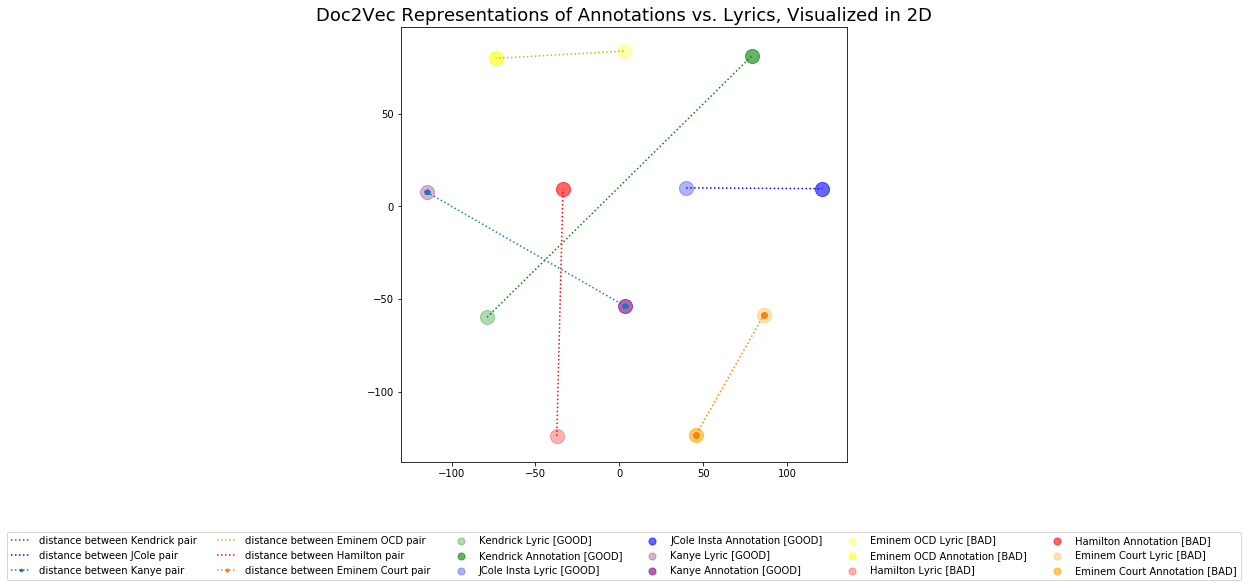

In [49]:
X = X_embedded_2[:,0]
y = X_embedded_2[:,1]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title("Doc2Vec Representations of Annotations vs. Lyrics, Visualized in 2D", fontsize=18)

# ax.scatter(x, y, s=size, alpha=0.4, c=colors)
# ax.scatter(X_embedded_2[0,0], s=size, alpha=0.3, c='blue', label='')

size = 200

ax.scatter(X[0], y[0], s=size, alpha=0.3, c='green', label='Kendrick Lyric [GOOD]')
ax.scatter(X[1], y[1], s=size, alpha=0.6, c='green', label='Kendrick Annotation [GOOD]')
ax.scatter(X[2], y[2], s=size, alpha=0.3, c='blue', label='JCole Insta Lyric [GOOD]')
ax.scatter(X[3], y[3], s=size, alpha=0.6, c='blue', label='JCole Insta Annotation [GOOD]')
ax.scatter(X[4], y[4], s=size, alpha=0.3, c='purple', label='Kanye Lyric [GOOD]')
ax.scatter(X[5], y[5], s=size, alpha=0.6, c='purple', label='Kanye Annotation [GOOD]')

ax.scatter(X[6], y[6], s=size, alpha=0.3, c='yellow', label='Eminem OCD Lyric [BAD]')
ax.scatter(X[7], y[7], s=size, alpha=0.6, c='yellow', label='Eminem OCD Annotation [BAD]')
ax.scatter(X[8], y[8], s=size, alpha=0.3, c='red', label='Hamilton Lyric [BAD]')
ax.scatter(X[9], y[9], s=size, alpha=0.6, c='red', label='Hamilton Annotation [BAD]')
ax.scatter(X[10], y[10], s=size, alpha=0.3, c='orange', label='Eminem Court Lyric [BAD]')
ax.scatter(X[11], y[11], s=size, alpha=0.6, c='orange', label='Eminem Court Annotation [BAD]')

plt.plot([X[0], X[1]], [y[0], y[1]], ':g', label = "distance between Kendrick pair");  # dotted red
plt.plot([X[2], X[3]], [y[2], y[3]], ':b', label = "distance between JCole pair");
plt.plot([X[4], X[5]], [y[4], y[5]], ':p', label = "distance between Kanye pair");  # dotted red

plt.plot([X[6], X[7]], [y[6], y[7]], ':y', label = "distance between Eminem OCD pair");
plt.plot([X[8], X[9]], [y[8], y[9]], ':r', label = "distance between Hamilton pair");  # dotted red
plt.plot([X[10], X[11]], [y[10], y[11]], ':o', label = "distance between Eminem Court pair");
# ax.scatter(0, 0.75, s=200, alpha=0.9, c='yellow', label='target_similarity')

# plt.xlim(-0.05, 0.74)
# plt.ylim(-0.05, 0.74);

# plt.axvline(x=train_true_ed.mean(), c='blue', alpha=0.3)
# plt.axvline(x=train_false_ed.mean(), c='red', alpha=0.3)
# plt.axhline(y=train_true_cs.mean(), c='blue', alpha=0.3)
# plt.axhline(y=train_false_cs.mean(), c='red', alpha=0.3)

# ax.set_xlabel('Avg Similarity of False Pairs', fontsize=16)
# ax.set_ylabel('Avg Similarity of True Pairs', fontsize=16)
ax.legend(loc='upper center', ncol=6, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

# fig.savefig('tr_tst_true_false_mean_cs.png')

In [50]:
colors_dict = {0: 'green', 1: 'green', 
                2: 'blue', 3:'blue', 
                4: 'purple', 5: 'purple', 
                6: 'yellow', 7: 'yellow', 
                8: 'red', 9: 'red', 
                10: 'orange', 11: 'orange'}

In [51]:
colors_dict[0][:1]

'g'

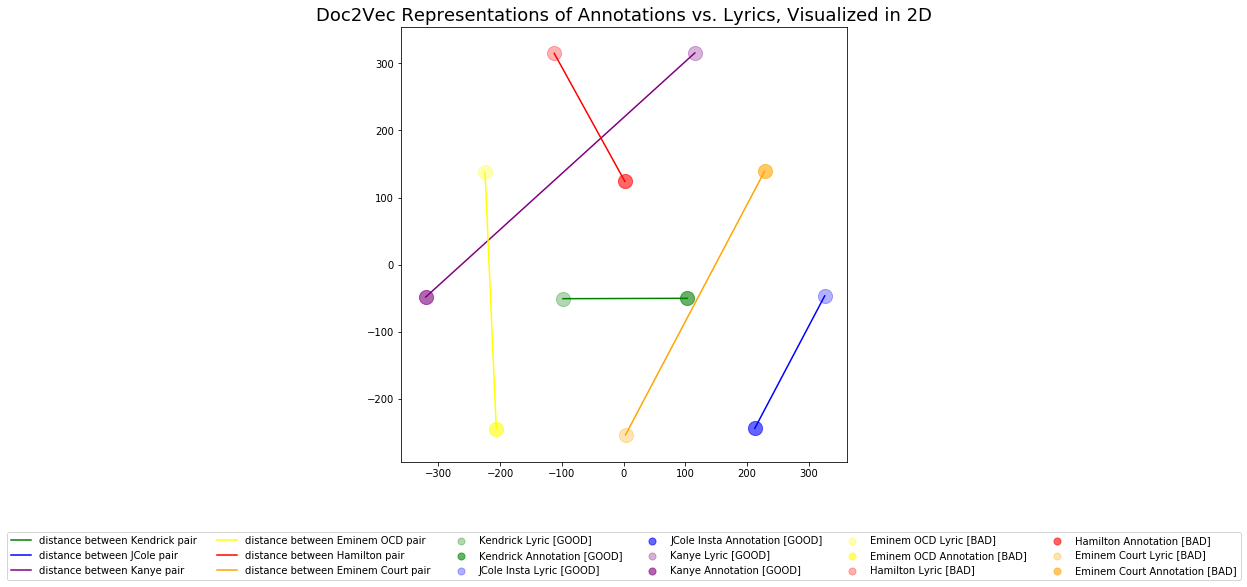

In [265]:
X = X_embedded_2[:,0]
y = X_embedded_2[:,1]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title("Doc2Vec Representations of Annotations vs. Lyrics, Visualized in 2D", fontsize=18)

# ax.scatter(x, y, s=size, alpha=0.4, c=colors)
# ax.scatter(X_embedded_2[0,0], s=size, alpha=0.3, c='blue', label='')

size = 200

ax.scatter(X[0], y[0], s=size, alpha=0.3, c='green', label='Kendrick Lyric [GOOD]')
ax.scatter(X[1], y[1], s=size, alpha=0.6, c='green', label='Kendrick Annotation [GOOD]')
ax.scatter(X[2], y[2], s=size, alpha=0.3, c='blue', label='JCole Insta Lyric [GOOD]')
ax.scatter(X[3], y[3], s=size, alpha=0.6, c='blue', label='JCole Insta Annotation [GOOD]')
ax.scatter(X[4], y[4], s=size, alpha=0.3, c='purple', label='Kanye Lyric [GOOD]')
ax.scatter(X[5], y[5], s=size, alpha=0.6, c='purple', label='Kanye Annotation [GOOD]')

ax.scatter(X[6], y[6], s=size, alpha=0.3, c='yellow', label='Eminem OCD Lyric [BAD]')
ax.scatter(X[7], y[7], s=size, alpha=0.6, c='yellow', label='Eminem OCD Annotation [BAD]')
ax.scatter(X[8], y[8], s=size, alpha=0.3, c='red', label='Hamilton Lyric [BAD]')
ax.scatter(X[9], y[9], s=size, alpha=0.6, c='red', label='Hamilton Annotation [BAD]')
ax.scatter(X[10], y[10], s=size, alpha=0.3, c='orange', label='Eminem Court Lyric [BAD]')
ax.scatter(X[11], y[11], s=size, alpha=0.6, c='orange', label='Eminem Court Annotation [BAD]')

plt.plot([X[0], X[1]], [y[0], y[1]], 'green', label = "distance between Kendrick pair");  # dotted red
plt.plot([X[2], X[3]], [y[2], y[3]], 'blue', label = "distance between JCole pair");
plt.plot([X[4], X[5]], [y[4], y[5]], 'purple', label = "distance between Kanye pair");  # dotted red

plt.plot([X[6], X[7]], [y[6], y[7]], 'yellow', label = "distance between Eminem OCD pair");
plt.plot([X[8], X[9]], [y[8], y[9]], 'red', label = "distance between Hamilton pair");  # dotted red
plt.plot([X[10], X[11]], [y[10], y[11]], 'orange', label = "distance between Eminem Court pair");
# ax.scatter(0, 0.75, s=200, alpha=0.9, c='yellow', label='target_similarity')

# plt.xlim(-0.05, 0.74)
# plt.ylim(-0.05, 0.74);

# plt.axvline(x=train_true_ed.mean(), c='blue', alpha=0.3)
# plt.axvline(x=train_false_ed.mean(), c='red', alpha=0.3)
# plt.axhline(y=train_true_cs.mean(), c='blue', alpha=0.3)
# plt.axhline(y=train_false_cs.mean(), c='red', alpha=0.3)

# ax.set_xlabel('Avg Similarity of False Pairs', fontsize=16)
# ax.set_ylabel('Avg Similarity of True Pairs', fontsize=16)
ax.legend(loc='upper center', ncol=6, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

# fig.savefig('tr_tst_true_false_mean_cs.png')

In [ ]:
# Import libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

# Create figure object
fig = plt.figure()

# Get the current axes, creating one if necessary.
ax = fig.gca(projection='3d')

# Get the Property Tax Report dataset
# Dataset link: https://data.vancouver.ca/datacatalogue/propertyTax.htm
data = pd.read_csv('property_tax_report_2018.csv')

# Extract the columns and do some transformations
yearWiseAgg = data[['PID','CURRENT_LAND_VALUE']].groupby(data['YEAR_BUILT']).agg({'PID':'count','CURRENT_LAND_VALUE':'sum'})
yearWiseAgg = yearWiseAgg.reset_index().dropna()

# Define colors as red, green, blue
colors = ['r', 'g', 'b']

# Get only records which have more than 2000 properties built per year
morethan2k = yearWiseAgg.query('PID>2000')

# Get shape of dataframe
dflen = morethan2k.shape[0]

# Fetch land values from dataframe
lanvalues = (morethan2k['CURRENT_LAND_VALUE']/2e6).tolist()

# Create a list of colors for each point corresponding to x and y
c_list = []
for i,value in enumerate(lanvalues):
    if value>0 and value<1900:
        c_list.append(colors[0])
    elif value>=1900 and value<2900:
        c_list.append(colors[1])
    else:
        c_list.append(colors[2])

# By using zdir='y', the y value of these points is fixed to the zs value 0
# and the (x,y) points are plotted on the x and z axes.
ax.scatter(morethan2k['PID'], morethan2k['YEAR_BUILT'], morethan2k['CURRENT_LAND_VALUE']/2e6,c=c_list)

# Set labels according to axis
plt.xlabel('Number of Properties')
plt.ylabel('Year Built')
ax.set_zlabel('Current land value (million)')

# Create customized legends 
legend_elements = [Line2D([0], [0], marker='o', color='w', label='No. of Properties with sum of land value price less than 1.9 millions',markerfacecolor='r', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Number of properties with their land value price less than 2.9 millions',markerfacecolor='g', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Number of properties with their land values greater than 2.9 millions',markerfacecolor='b', markersize=10)
                  ]
                   
# Make legend
ax.legend(handles=legend_elements, loc='best')

plt.show()

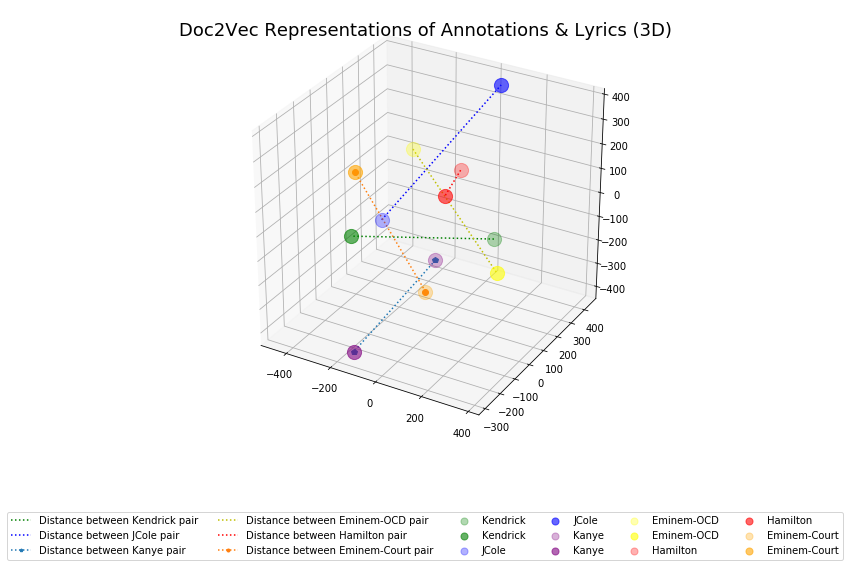

In [57]:
# Import libraries
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

save_fig=False

X = X_embedded_3[:,0]
y = X_embedded_3[:,1]
z = X_embedded_3[:,2]

# Gotta find a way to do this w/o hardcoding...
colors_dict = {0: 'green', 1: 'green',
            2: 'blue', 3:'blue',
            4: 'purple', 5: 'purple',
            6: 'yellow', 7: 'yellow',
            8: 'red', 9: 'red',
            10: 'orange', 11: 'orange'}

pair_labels_dict = {0: 'Kendrick', 1: 'Kendrick',
            2: 'JCole', 3: 'JCole',
            4: 'Kanye', 5: 'Kanye',
            6: 'Eminem-OCD', 7: 'Eminem-OCD',
            8: 'Hamilton', 9: 'Hamilton',
            10: 'Eminem-Court', 11: 'Eminem-Court'}

group_name = 'initial_handpicked'


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Doc2Vec Representations of Annotations & Lyrics (3D)", fontsize=18)

size = 200
n_docs = X_embedded_3.shape[0]
n_pairs = n_docs / 2

for idx in range(n_docs):
    is_odd_idx = idx % 2 != 0
    alpha = 0.6 if is_odd_idx else 0.3
    ax.scatter(X[idx], y[idx], z[idx], s=size, alpha=alpha, c=colors_dict[idx], label=pair_labels_dict[idx])

    if is_odd_idx:
        label_text = "Distance between {0} pair".format(pair_labels_dict[idx])
        line_format = ':' + colors_dict[idx][:1]
        plt.plot([X[idx-1], X[idx]], [y[idx-1], y[idx]], [z[idx-1], z[idx]], line_format, label=label_text);

ax.legend(loc='upper center', ncol=int(n_pairs), markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

if save_fig:
    file_name = '../images/{}_3d_tsne_plot.png'.format(groupname)
    fig.savefig(file_name)

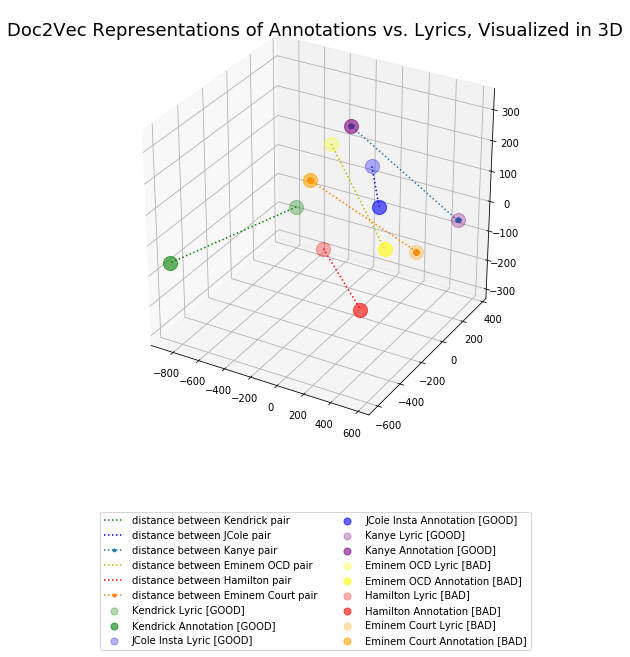

In [174]:
# Import libraries
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

# Create figure object
fig = plt.figure()

# Get the current axes, creating one if necessary.
ax = fig.gca(projection='3d')

X = X_embedded_3[:,0]
y = X_embedded_3[:,1]
z = X_embedded_3[:,2]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Doc2Vec Representations of Annotations vs. Lyrics, Visualized in 3D", fontsize=18)

# ax.scatter(x, y, s=size, alpha=0.4, c=colors)
# ax.scatter(X_embedded_2[0,0], s=size, alpha=0.3, c='blue', label='')

size = 200

ax.scatter(X[0], y[0], z[0], s=size, alpha=0.3, c='green', label='Kendrick Lyric [GOOD]')
ax.scatter(X[1], y[1], z[1], s=size, alpha=0.6, c='green', label='Kendrick Annotation [GOOD]')
ax.scatter(X[2], y[2], z[2], s=size, alpha=0.3, c='blue', label='JCole Insta Lyric [GOOD]')
ax.scatter(X[3], y[3], z[3], s=size, alpha=0.6, c='blue', label='JCole Insta Annotation [GOOD]')
ax.scatter(X[4], y[4], z[4], s=size, alpha=0.3, c='purple', label='Kanye Lyric [GOOD]')
ax.scatter(X[5], y[5], z[5], s=size, alpha=0.6, c='purple', label='Kanye Annotation [GOOD]')

ax.scatter(X[6], y[6], z[6], s=size, alpha=0.3, c='yellow', label='Eminem OCD Lyric [BAD]')
ax.scatter(X[7], y[7], z[7], s=size, alpha=0.6, c='yellow', label='Eminem OCD Annotation [BAD]')
ax.scatter(X[8], y[8], z[8], s=size, alpha=0.3, c='red', label='Hamilton Lyric [BAD]')
ax.scatter(X[9], y[9], z[9], s=size, alpha=0.6, c='red', label='Hamilton Annotation [BAD]')
ax.scatter(X[10], y[10], z[10], s=size, alpha=0.3, c='orange', label='Eminem Court Lyric [BAD]')
ax.scatter(X[11], y[11], z[11], s=size, alpha=0.6, c='orange', label='Eminem Court Annotation [BAD]')

plt.plot([X[0], X[1]], [y[0], y[1]], [z[0], z[1]], ':g', label = "distance between Kendrick pair");  # dotted red
plt.plot([X[2], X[3]], [y[2], y[3]], [z[2], z[3]], ':b', label = "distance between JCole pair");
plt.plot([X[4], X[5]], [y[4], y[5]], [z[4], z[5]], ':p', label = "distance between Kanye pair");  # dotted red

plt.plot([X[6], X[7]], [y[6], y[7]], [z[6], z[7]], ':y', label = "distance between Eminem OCD pair");
plt.plot([X[8], X[9]], [y[8], y[9]], [z[8], z[9]], ':r', label = "distance between Hamilton pair");  # dotted red
plt.plot([X[10], X[11]], [y[10], y[11]], [z[10], z[11]], ':o', label = "distance between Eminem Court pair");



# ax.scatter(0, 0.75, s=200, alpha=0.9, c='yellow', label='target_similarity')

# plt.xlim(-0.05, 0.74)
# plt.ylim(-0.05, 0.74);

# plt.axvline(x=train_true_ed.mean(), c='blue', alpha=0.3)
# plt.axvline(x=train_false_ed.mean(), c='red', alpha=0.3)
# plt.axhline(y=train_true_cs.mean(), c='blue', alpha=0.3)
# plt.axhline(y=train_false_cs.mean(), c='red', alpha=0.3)

# ax.set_xlabel('Avg Similarity of False Pairs', fontsize=16)
# ax.set_ylabel('Avg Similarity of True Pairs', fontsize=16)
ax.legend(loc='upper center', ncol=6, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

# fig.savefig('tr_tst_true_false_mean_cs.png')

In [ ]:
tr_pair_df = rt_50.tr_pairings_df
is_good_rtid = tr_pair_df[tr_pair_df['ref_id'].isin(good)]
good_info_df = is_good_rtid[is_good_rtid['is_pair'] == 1][['ref_id', 'ref_raw_text', 'tate_raw_text', 'pair_cs', 'pair_ed']]
good_info_df

In [ ]:
tr_pair_df = rt_50.tr_pairings_df
is_bad_rtid = tr_pair_df[tr_pair_df['ref_id'].isin(bad)]
bad_info_df = is_bad_rtid[is_bad_rtid['is_pair'] == 1][['ref_id', 'ref_raw_text', 'tate_raw_text', 'pair_cs', 'pair_ed']]
bad_info_df

In [190]:
good_info_df['pair_cs'].values * 100

array([26.69520974, 24.04829562, 18.90772581])

In [ ]:
all3_info = pd.concat([good_info_df[['ref_id', 'pair_cs', 'pair_ed']], bad_info_df[['ref_id', 'pair_cs', 'pair_ed']]])
all3_info

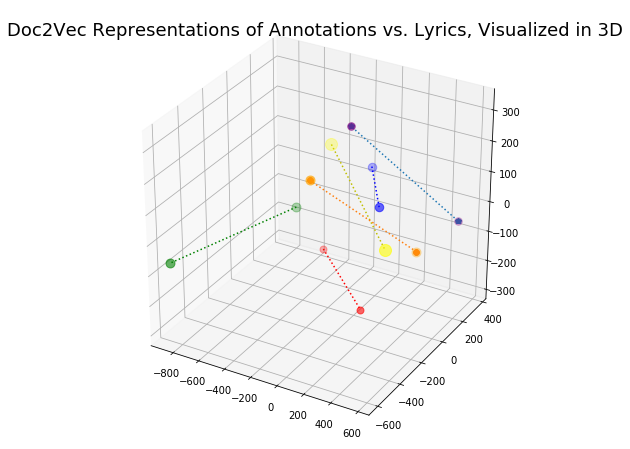

In [194]:
X = X_embedded_3[:,0]
y = X_embedded_3[:,1]
z = X_embedded_3[:,2]

scale = 300

gs_cs = good_info_df['pair_cs'].values * scale
bs_cs = bad_info_df['pair_cs'].values * scale

gs_ed = good_info_df['pair_ed'].values * scale
bs_ed = bad_info_df['pair_ed'].values * scale

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Doc2Vec Representations of Annotations vs. Lyrics, Visualized in 3D", fontsize=18)

# ax.scatter(x, y, s=size, alpha=0.4, c=colors)
# ax.scatter(X_embedded_2[0,0], s=size, alpha=0.3, c='blue', label='')

# size = 200

ax.scatter(X[0], y[0], z[0], s=gs_cs[0], alpha=0.3, c='green', label='Kendrick Lyric [GOOD]')
ax.scatter(X[1], y[1], z[1], s=gs_cs[0], alpha=0.6, c='green', label='Kendrick Annotation [GOOD]')
ax.scatter(X[2], y[2], z[2], s=gs_cs[1], alpha=0.3, c='blue', label='JCole Insta Lyric [GOOD]')
ax.scatter(X[3], y[3], z[3], s=gs_cs[1], alpha=0.6, c='blue', label='JCole Insta Annotation [GOOD]')
ax.scatter(X[4], y[4], z[4], s=gs_cs[2], alpha=0.3, c='purple', label='Kanye Lyric [GOOD]')
ax.scatter(X[5], y[5], z[5], s=gs_cs[2], alpha=0.6, c='purple', label='Kanye Annotation [GOOD]')

ax.scatter(X[6], y[6], z[6], s=bs_cs[0], alpha=0.3, c='yellow', label='Eminem OCD Lyric [BAD]')
ax.scatter(X[7], y[7], z[7], s=bs_cs[0], alpha=0.6, c='yellow', label='Eminem OCD Annotation [BAD]')
ax.scatter(X[8], y[8], z[8], s=bs_cs[1], alpha=0.3, c='red', label='Hamilton Lyric [BAD]')
ax.scatter(X[9], y[9], z[9], s=bs_cs[1], alpha=0.6, c='red', label='Hamilton Annotation [BAD]')
ax.scatter(X[10], y[10], z[10], s=bs_cs[2], alpha=0.3, c='orange', label='Eminem Court Lyric [BAD]')
ax.scatter(X[11], y[11], z[11], s=bs_cs[2], alpha=0.6, c='orange', label='Eminem Court Annotation [BAD]')

plt.plot([X[0], X[1]], [y[0], y[1]], [z[0], z[1]], ':g', label = "distance between Kendrick pair");  # dotted red
plt.plot([X[2], X[3]], [y[2], y[3]], [z[2], z[3]], ':b', label = "distance between JCole pair");
plt.plot([X[4], X[5]], [y[4], y[5]], [z[4], z[5]], ':p', label = "distance between Kanye pair");  # dotted red

plt.plot([X[6], X[7]], [y[6], y[7]], [z[6], z[7]], ':y', label = "distance between Eminem OCD pair");
plt.plot([X[8], X[9]], [y[8], y[9]], [z[8], z[9]], ':r', label = "distance between Hamilton pair");  # dotted red
plt.plot([X[10], X[11]], [y[10], y[11]], [z[10], z[11]], ':o', label = "distance between Eminem Court pair");



# ax.scatter(0, 0.75, s=200, alpha=0.9, c='yellow', label='target_similarity')

# plt.xlim(-0.05, 0.74)
# plt.ylim(-0.05, 0.74);

# plt.axvline(x=train_true_ed.mean(), c='blue', alpha=0.3)
# plt.axvline(x=train_false_ed.mean(), c='red', alpha=0.3)
# plt.axhline(y=train_true_cs.mean(), c='blue', alpha=0.3)
# plt.axhline(y=train_false_cs.mean(), c='red', alpha=0.3)

# ax.set_xlabel('Avg Similarity of False Pairs', fontsize=16)
# ax.set_ylabel('Avg Similarity of True Pairs', fontsize=16)
ax.legend(loc='upper center', ncol=6, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

# fig.savefig('tr_tst_true_false_mean_cs.png')

In [195]:
from matplotlib.ticker import MaxNLocator

In [196]:
gs_cs.shape[0] + bs_cs.shape[0]

6

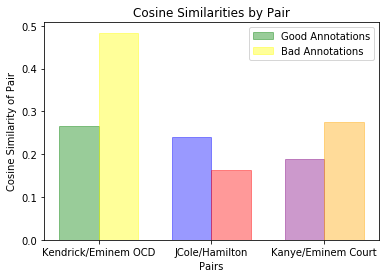

In [203]:
gs_cs = good_info_df['pair_cs'].values
bs_cs = bad_info_df['pair_cs'].values

# gs_ed = good_info_df['pair_ed'].values
# bs_ed = bad_info_df['pair_ed'].values

n_groups = gs_cs.shape[0]

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, gs_cs, bar_width,
                alpha=opacity, error_kw=error_config,
                label='Good Annotations')

rects2 = ax.bar(index + bar_width, bs_cs, bar_width,
                alpha=opacity, error_kw=error_config,
                label='Bad Annotations')

rects1[0].set_color('green')
rects1[1].set_color('blue')
rects1[2].set_color('purple')
rects2[0].set_color('yellow')
rects2[1].set_color('red')
rects2[2].set_color('orange')

ax.set_xlabel('Pairs')
ax.set_ylabel('Cosine Similarity of Pair')
ax.set_title('Cosine Similarities by Pair')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Kendrick/Eminem OCD', 'JCole/Hamilton', 'Kanye/Eminem Court'))
ax.legend()

# fig.tight_layout()
plt.show()

In [209]:
all3_info

,ref_id,pair_cs,pair_ed
663,14695297,0.266952,11.277062
1266,14369122,0.240483,12.532324
1313,5057218,0.189077,13.602887
1408,13660449,0.483733,4.617210
1709,9176821,0.162099,8.962246
1969,9224654,0.274885,8.518106


In [210]:
all3_cs_df = all3_info.copy()
# sort df by Count column
all3_cs_df = all3_cs_df.sort_values(['pair_cs']).reset_index(drop=True)
all3_cs_df

,ref_id,pair_cs,pair_ed
0,9176821,0.162099,8.962246
1,5057218,0.189077,13.602887
2,14369122,0.240483,12.532324
3,14695297,0.266952,11.277062
4,9224654,0.274885,8.518106
5,13660449,0.483733,4.617210


In [ ]:
all3_info = pd.concat([good_info_df, bad_info_df])
all3_info

In [241]:
all3_cs_df = all3_info.sort_values(['pair_cs']).reset_index(drop=True)
all3_cs_df

,ref_id,ref_raw_text,tate_raw_text,pair_cs,pair_ed
0,9176821,‘Cause the very thing that I love's killin' me...,I really do have O.C.D. it’s not funny bitch.,0.162099,8.962246
1,5057218,"I should distance myself, I should keep it rel...",Kendrick continues to provide excuses for not ...,0.189077,13.602887
2,14369122,Fell in love through photograph\n I don't even...,Cole expresses how in the era of Instagram and...,0.240483,12.532324
3,14695297,"Let me hit it raw like fuck the outcome\n Ayy,...",Having sex without a condom—“hitting it raw”—i...,0.266952,11.277062
4,9224654,"Go call you a lawyer, file you a lawsuit\n I'l...",Every time I have had a court issue since this...,0.274885,8.518106
5,13660449,Hamilton,It bothered me that this wasn’t highlighted li...,0.483733,4.617210


In [ ]:
cs_order_ltm = ['Eminem-OCD', 'Kendrick', 'JCole', 'Kanye', 'Eminem-Court', 'Hamilton']
cs_color_ltm = ['yellow', 'green', 'blue', 'purple', 'orange', 'red']

colors = ['green', 'blue', 'purple', 'yellow', 'red', 'orange']
pair_labels = ['Kendrick', 'JCole', 'Kanye', 'Eminem-OCD', 'Hamilton', 'Eminem-Court']

In [242]:
all3_ed_df = all3_info.sort_values(['pair_ed']).reset_index(drop=True)
all3_ed_df

,ref_id,ref_raw_text,tate_raw_text,pair_cs,pair_ed
0,13660449,Hamilton,It bothered me that this wasn’t highlighted li...,0.483733,4.617210
1,9224654,"Go call you a lawyer, file you a lawsuit\n I'l...",Every time I have had a court issue since this...,0.274885,8.518106
2,9176821,‘Cause the very thing that I love's killin' me...,I really do have O.C.D. it’s not funny bitch.,0.162099,8.962246
3,14695297,"Let me hit it raw like fuck the outcome\n Ayy,...",Having sex without a condom—“hitting it raw”—i...,0.266952,11.277062
4,14369122,Fell in love through photograph\n I don't even...,Cole expresses how in the era of Instagram and...,0.240483,12.532324
5,5057218,"I should distance myself, I should keep it rel...",Kendrick continues to provide excuses for not ...,0.189077,13.602887


In [ ]:
for idx in range(6):
    feel = "GOOD" if idx < 3 else "BAD"
    print("\n{0} LYRIC:".format(feel))
    print(all3_info['ref_raw_text'].values)
    print("\n{0} ANNOTATION:".format(feel))
    print(all3_info['tate_raw_text'].values)

In [ ]:
cs_order_ltm = ['Hamilton', 'Eminem-Court', 'Eminem-OCD', 'Kanye', 'JCole', 'Kendrick']
cs_color_ltm = ['red', 'orange', 'yellow', 'purple', 'blue', 'green']

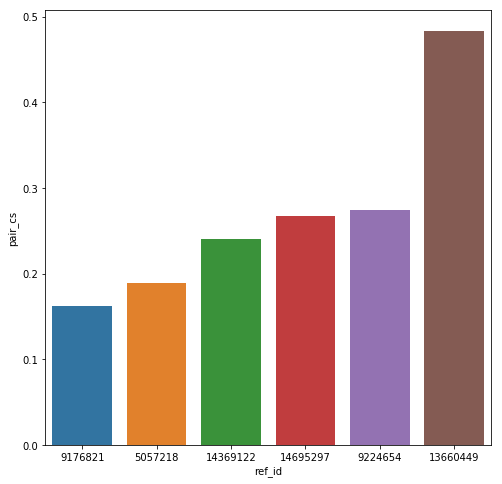

In [215]:
import seaborn as sns

plt.figure(figsize=(8,8))
# plot barh chart with index as x values
ax = sns.barplot(all3_cs_df.index, all3_cs_df.pair_cs)

# ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax.set(xlabel="ref_id", ylabel='pair_cs')
# add proper Dim values as x labels
ax.set_xticklabels(all3_cs_df.ref_id)

# for item in ax.get_xticklabels(): item.set_rotation(90)
    
# for i, v in enumerate(all3_cs_df["pair_cs"].iteritems()):        
#     ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', rotation=45)
    
# plt.tight_layout()
plt.show()

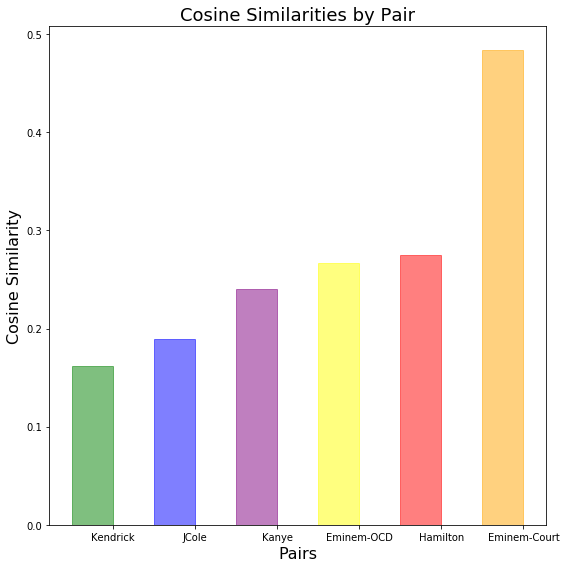

In [234]:
n_groups = gs_cs.shape[0] + bs_cs.shape[0]

fig, ax = plt.subplots(figsize=(8,8))

index = np.arange(n_groups)
bar_width = 0.5

opacity = 0.5

rects = ax.bar(index, all3_cs_df['pair_cs'], bar_width,
                alpha=opacity)

# rects2 = ax.bar(index + bar_width, bs_cs, bar_width,
#                 alpha=opacity, error_kw=error_config,
#                 label='Bad Annotations')

colors = ['green', 'blue', 'purple', 'yellow', 'red', 'orange']
pair_labels = ['Kendrick', 'JCole', 'Kanye', 'Eminem-OCD', 'Hamilton', 'Eminem-Court']

for idx in range(n_groups):
    rects[idx].set_color(colors[idx])
    rects[idx].set_label(pair_labels[idx])


# rects1[0].set_color('green')
# rects1[0].set_color('green')
# rects1[1].set_color('blue')
# rects1[2].set_color('purple')
# rects2[0].set_color('yellow')
# rects2[1].set_color('red')
# rects2[2].set_color('orange')

ax.set_xlabel('Pairs', fontsize=16)
ax.set_ylabel('Cosine Similarity', fontsize=16)
ax.set_title('Cosine Similarities by Pair', fontsize=18)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(pair_labels)
# ax.legend()

fig.tight_layout()
plt.show()

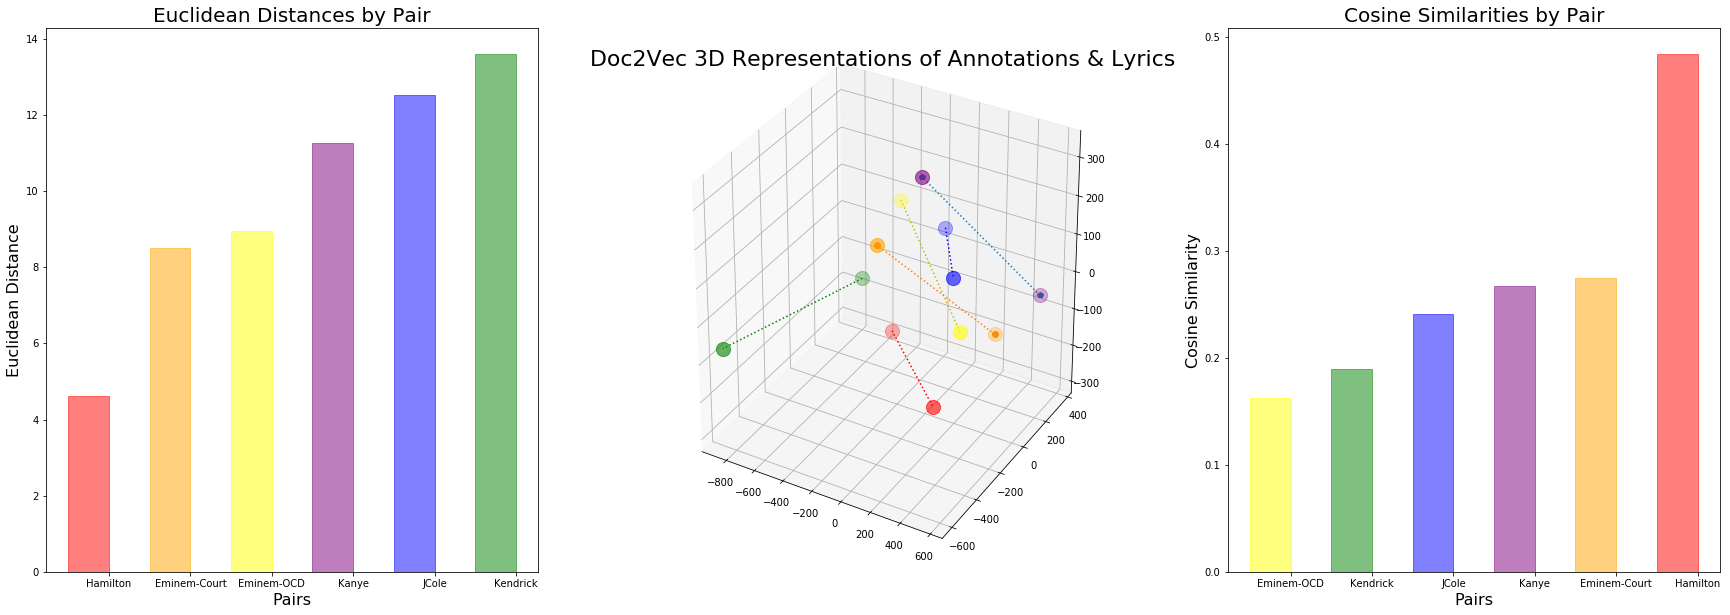

In [261]:
fig = plt.figure(figsize=(30,10))

ax = fig.add_subplot(132, projection='3d')

ax.set_title("Doc2Vec 3D Representations of Annotations & Lyrics", fontsize=22)

X = X_embedded_3[:,0]
y = X_embedded_3[:,1]
z = X_embedded_3[:,2]

size = 200

ax.scatter(X[0], y[0], z[0], s=size, alpha=0.3, c='green', label='Kendrick Lyric [GOOD]')
ax.scatter(X[1], y[1], z[1], s=size, alpha=0.6, c='green', label='Kendrick Annotation [GOOD]')
ax.scatter(X[2], y[2], z[2], s=size, alpha=0.3, c='blue', label='JCole Insta Lyric [GOOD]')
ax.scatter(X[3], y[3], z[3], s=size, alpha=0.6, c='blue', label='JCole Insta Annotation [GOOD]')
ax.scatter(X[4], y[4], z[4], s=size, alpha=0.3, c='purple', label='Kanye Lyric [GOOD]')
ax.scatter(X[5], y[5], z[5], s=size, alpha=0.6, c='purple', label='Kanye Annotation [GOOD]')

ax.scatter(X[6], y[6], z[6], s=size, alpha=0.3, c='yellow', label='Eminem OCD Lyric [BAD]')
ax.scatter(X[7], y[7], z[7], s=size, alpha=0.6, c='yellow', label='Eminem OCD Annotation [BAD]')
ax.scatter(X[8], y[8], z[8], s=size, alpha=0.3, c='red', label='Hamilton Lyric [BAD]')
ax.scatter(X[9], y[9], z[9], s=size, alpha=0.6, c='red', label='Hamilton Annotation [BAD]')
ax.scatter(X[10], y[10], z[10], s=size, alpha=0.3, c='orange', label='Eminem Court Lyric [BAD]')
ax.scatter(X[11], y[11], z[11], s=size, alpha=0.6, c='orange', label='Eminem Court Annotation [BAD]')

plt.plot([X[0], X[1]], [y[0], y[1]], [z[0], z[1]], ':g', label = "distance between Kendrick pair");  # dotted red
plt.plot([X[2], X[3]], [y[2], y[3]], [z[2], z[3]], ':b', label = "distance between JCole pair");
plt.plot([X[4], X[5]], [y[4], y[5]], [z[4], z[5]], ':p', label = "distance between Kanye pair");  # dotted red

plt.plot([X[6], X[7]], [y[6], y[7]], [z[6], z[7]], ':y', label = "distance between Eminem OCD pair");
plt.plot([X[8], X[9]], [y[8], y[9]], [z[8], z[9]], ':r', label = "distance between Hamilton pair");  # dotted red
plt.plot([X[10], X[11]], [y[10], y[11]], [z[10], z[11]], ':o', label = "distance between Eminem Court pair");



ax2 = fig.add_subplot(133)

n_groups = gs_cs.shape[0] + bs_cs.shape[0]

index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.5

rects1 = ax2.bar(index, all3_cs_df['pair_cs'], bar_width,
                alpha=opacity)

cs_pair_labels = ['Eminem-OCD', 'Kendrick', 'JCole', 'Kanye', 'Eminem-Court', 'Hamilton']
cs_colors = ['yellow', 'green', 'blue', 'purple', 'orange', 'red']

for idx in range(n_groups):
    rects1[idx].set_color(cs_colors[idx])
    rects1[idx].set_label(cs_pair_labels[idx])

ax2.set_xlabel('Pairs', fontsize=16)
ax2.set_ylabel('Cosine Similarity', fontsize=16)
ax2.set_title('Cosine Similarities by Pair', fontsize=20)
ax2.set_xticks(index + bar_width / 2)
ax2.set_xticklabels(cs_pair_labels)
# ax.legend()
# fig.tight_layout()


ax3 = fig.add_subplot(131)

n_groups = gs_cs.shape[0] + bs_cs.shape[0]

index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.5


rects2 = ax3.bar(index, all3_ed_df['pair_ed'], bar_width,
                alpha=opacity)

ed_pair_labels = ['Hamilton', 'Eminem-Court', 'Eminem-OCD', 'Kanye', 'JCole', 'Kendrick']
ed_colors = ['red', 'orange', 'yellow', 'purple', 'blue', 'green']

for idx in range(n_groups):
    rects2[idx].set_color(ed_colors[idx])
    rects2[idx].set_label(ed_pair_labels[idx])

ax3.set_xlabel('Pairs', fontsize=16)
ax3.set_ylabel('Euclidean Distance', fontsize=16)
ax3.set_title('Euclidean Distances by Pair', fontsize=20)
ax3.set_xticks(index + bar_width / 2)
ax3.set_xticklabels(ed_pair_labels)


plt.show()

fig.savefig('../images/comp_dist_3D_dv_reps.png')

In [258]:
all3_cs_df

,ref_id,ref_raw_text,tate_raw_text,pair_cs,pair_ed
0,9176821,‘Cause the very thing that I love's killin' me...,I really do have O.C.D. it’s not funny bitch.,0.162099,8.962246
1,5057218,"I should distance myself, I should keep it rel...",Kendrick continues to provide excuses for not ...,0.189077,13.602887
2,14369122,Fell in love through photograph\n I don't even...,Cole expresses how in the era of Instagram and...,0.240483,12.532324
3,14695297,"Let me hit it raw like fuck the outcome\n Ayy,...",Having sex without a condom—“hitting it raw”—i...,0.266952,11.277062
4,9224654,"Go call you a lawyer, file you a lawsuit\n I'l...",Every time I have had a court issue since this...,0.274885,8.518106
5,13660449,Hamilton,It bothered me that this wasn’t highlighted li...,0.483733,4.617210


In [157]:
good_ref_vecs

array([[[-0.9346913 ,  0.15784484, -1.0815604 ,  0.27753487,
          0.00554886, -0.36635724, -1.4390299 , -0.8216966 ,
         -1.1764957 , -1.3209455 , -3.4171662 ,  2.2644444 ,
          0.55247045,  0.45953792,  1.1193094 , -1.1218666 ,
         -0.5069539 , -1.9343892 ,  2.0811493 ,  0.5795949 ,
         -0.9073572 , -1.3727683 , -0.0612128 ,  1.4782927 ,
          1.1777995 , -0.6912324 ,  2.6547685 , -0.12290318,
         -1.9371715 , -2.8784077 , -0.82271844, -2.376649  ,
          0.90872264,  1.1134615 ,  0.5882945 , -0.5241396 ,
          0.47662476,  2.417324  ,  1.2785109 , -2.0721247 ,
         -1.2407951 , -0.7951501 , -2.51115   ,  2.3797479 ,
          0.7705768 ,  1.0458041 ,  0.3115051 ,  0.74580437,
          1.3769552 , -0.60670614]],

       [[-1.1951551 ,  0.23331714,  2.9374835 ,  0.5726553 ,
          1.8749411 , -0.5427787 ,  1.4833262 , -1.8602136 ,
          0.6227816 , -1.5281285 , -1.2187432 , -0.04569277,
          0.56793153,  0.4814473 ,  2.1664922 ,

In [124]:
good_ref_vecs[0]

array([[-0.9346913 ,  0.15784484, -1.0815604 ,  0.27753487,  0.00554886,
        -0.36635724, -1.4390299 , -0.8216966 , -1.1764957 , -1.3209455 ,
        -3.4171662 ,  2.2644444 ,  0.55247045,  0.45953792,  1.1193094 ,
        -1.1218666 , -0.5069539 , -1.9343892 ,  2.0811493 ,  0.5795949 ,
        -0.9073572 , -1.3727683 , -0.0612128 ,  1.4782927 ,  1.1777995 ,
        -0.6912324 ,  2.6547685 , -0.12290318, -1.9371715 , -2.8784077 ,
        -0.82271844, -2.376649  ,  0.90872264,  1.1134615 ,  0.5882945 ,
        -0.5241396 ,  0.47662476,  2.417324  ,  1.2785109 , -2.0721247 ,
        -1.2407951 , -0.7951501 , -2.51115   ,  2.3797479 ,  0.7705768 ,
         1.0458041 ,  0.3115051 ,  0.74580437,  1.3769552 , -0.60670614]],
      dtype=float32)

In [134]:
full_array = np.concatenate([good_ref_vecs[2], good_tate_vecs[2], bad_ref_vecs[2], bad_tate_vecs[2]])
full_array.shape

(4, 50)

In [135]:
good_tate_vecs[2]

array([[-0.00462827, -0.14763156,  1.0978563 , -0.48153082, -0.24838935,
         1.5449271 ,  0.697407  , -0.8255664 , -0.08825745, -0.86547786,
        -2.0074675 , -0.47553772, -1.4695681 ,  1.2156078 , -0.15340881,
        -0.9663998 , -1.3896668 , -0.3462234 , -1.7998456 ,  0.934531  ,
        -2.4153998 ,  1.6495498 ,  1.8413056 , -0.26262167,  0.31544274,
        -1.0793664 , -0.8330568 , -0.2158062 , -1.4808729 , -0.861694  ,
        -2.0048575 ,  1.4038488 ,  0.07442358,  1.423553  , -0.71121126,
         0.8087991 , -1.4140823 , -0.7025652 ,  0.4568437 ,  0.7977809 ,
        -1.5649055 , -0.9550389 ,  1.4581814 ,  0.59082294, -0.7169834 ,
         0.06678532,  0.6081364 , -1.6150832 ,  2.030158  , -2.5174668 ]],
      dtype=float32)

In [136]:
full_array

array([[-0.18427542,  0.62613785, -0.9420295 ,  1.434805  , -1.7172015 ,
         1.2093933 , -1.1452277 ,  0.24430731, -1.0507603 , -1.9973209 ,
        -1.835168  ,  0.89493895, -0.2808278 ,  1.6437525 , -1.0291959 ,
        -0.52319807,  0.8520707 ,  1.2380824 ,  2.4737413 ,  0.13731809,
        -0.4083205 , -0.42857322,  2.0572147 , -0.31792066, -0.570662  ,
        -1.960124  ,  1.9728104 ,  0.32857692,  0.61313   , -1.0053711 ,
         0.5393457 ,  1.1745279 ,  2.3624864 ,  1.2061726 ,  0.31241113,
         0.31872642, -1.6106666 , -1.2446988 ,  0.30214706, -1.5633954 ,
        -1.7340581 , -0.20368633, -0.3519246 , -0.05115147, -1.1367881 ,
         1.587024  ,  0.5468183 , -0.26923743,  0.7324633 , -1.5486655 ],
       [-0.00462827, -0.14763156,  1.0978563 , -0.48153082, -0.24838935,
         1.5449271 ,  0.697407  , -0.8255664 , -0.08825745, -0.86547786,
        -2.0074675 , -0.47553772, -1.4695681 ,  1.2156078 , -0.15340881,
        -0.9663998 , -1.3896668 , -0.3462234 , -1.

In [137]:
X_embedded_2 = TSNE(n_components=2, random_state=42).fit_transform(full_array)
X_embedded_3 = TSNE(n_components=3, random_state=42).fit_transform(full_array)

print(X_embedded_2)
print(X_embedded_3)

[[ -36.12008  -230.6465  ]
 [-173.6626   -141.52928 ]
 [-149.45114  -254.86096 ]
 [ -60.331535 -117.31477 ]]
[[-138.07468      2.5429094  240.61365  ]
 [ 213.11134   -119.83793     21.552473 ]
 [ 103.77644    260.83234   -111.82576  ]
 [-179.19235   -127.97035   -161.52007  ]]


In [138]:
X_embedded_2[:,0]

array([ -36.12008 , -173.6626  , -149.45114 ,  -60.331535], dtype=float32)

In [140]:
X_embedded_2[0,0]

-36.12008

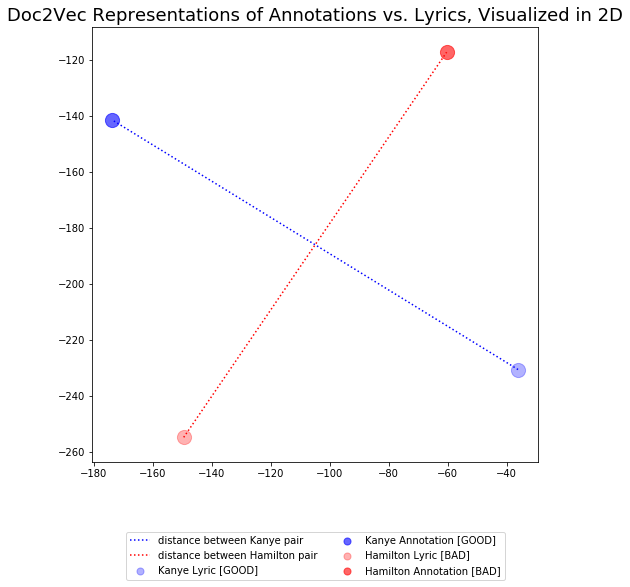

In [148]:
X = X_embedded_2[:,0]
y = X_embedded_2[:,1]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title("Doc2Vec Representations of Annotations vs. Lyrics, Visualized in 2D", fontsize=18)

# ax.scatter(x, y, s=size, alpha=0.4, c=colors)
# ax.scatter(X_embedded_2[0,0], s=size, alpha=0.3, c='blue', label='')

size = 200

ax.scatter(X[0], y[0], s=size, alpha=0.3, c='blue', label='Kanye Lyric [GOOD]')
ax.scatter(X[1], y[1], s=size, alpha=0.6, c='blue', label='Kanye Annotation [GOOD]')
ax.scatter(X[2], y[2], s=size, alpha=0.3, c='red', label='Hamilton Lyric [BAD]')
ax.scatter(X[3], y[3], s=size, alpha=0.6, c='red', label='Hamilton Annotation [BAD]')

plt.plot([X[0], X[1]], [y[0], y[1]], ':b', label = "distance between Kanye pair");  # dotted red
plt.plot([X[2], X[3]], [y[2], y[3]], ':r', label = "distance between Hamilton pair");
# ax.scatter(0, 0.75, s=200, alpha=0.9, c='yellow', label='target_similarity')

# plt.xlim(-0.05, 0.74)
# plt.ylim(-0.05, 0.74);

# plt.axvline(x=train_true_ed.mean(), c='blue', alpha=0.3)
# plt.axvline(x=train_false_ed.mean(), c='red', alpha=0.3)
# plt.axhline(y=train_true_cs.mean(), c='blue', alpha=0.3)
# plt.axhline(y=train_false_cs.mean(), c='red', alpha=0.3)

# ax.set_xlabel('Avg Similarity of False Pairs', fontsize=16)
# ax.set_ylabel('Avg Similarity of True Pairs', fontsize=16)
ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

# fig.savefig('tr_tst_true_false_mean_cs.png')

In [151]:
from mpl_toolkits.mplot3d import Axes3D

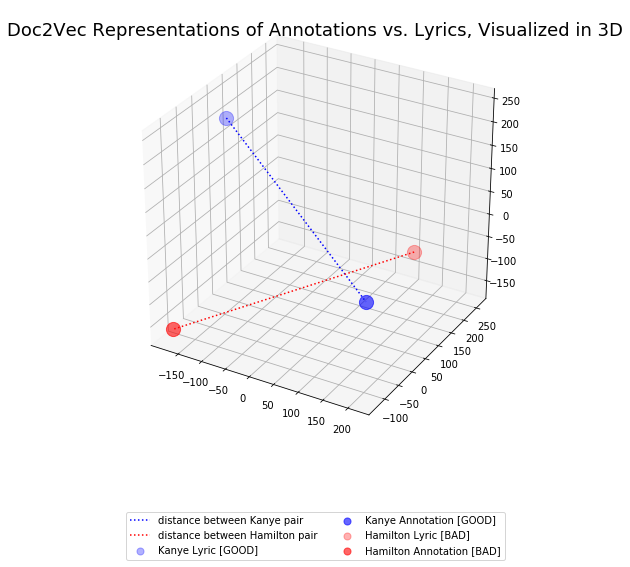

In [153]:
X = X_embedded_3[:,0]
y = X_embedded_3[:,1]
z = X_embedded_3[:,2]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Doc2Vec Representations of Annotations vs. Lyrics, Visualized in 3D", fontsize=18)

# ax.scatter(x, y, s=size, alpha=0.4, c=colors)
# ax.scatter(X_embedded_2[0,0], s=size, alpha=0.3, c='blue', label='')

size = 200

ax.scatter(X[0], y[0], z[0], s=size, alpha=0.3, c='blue', label='Kanye Lyric [GOOD]')
ax.scatter(X[1], y[1], z[1], s=size, alpha=0.6, c='blue', label='Kanye Annotation [GOOD]')
ax.scatter(X[2], y[2], z[2], s=size, alpha=0.3, c='red', label='Hamilton Lyric [BAD]')
ax.scatter(X[3], y[3], z[3], s=size, alpha=0.6, c='red', label='Hamilton Annotation [BAD]')

plt.plot([X[0], X[1]], [y[0], y[1]], [z[0], z[1]], ':b', label = "distance between Kanye pair");  # dotted red
plt.plot([X[2], X[3]], [y[2], y[3]], [z[2], z[3]], ':r', label = "distance between Hamilton pair");
# ax.scatter(0, 0.75, s=200, alpha=0.9, c='yellow', label='target_similarity')

# plt.xlim(-0.05, 0.74)
# plt.ylim(-0.05, 0.74);

# plt.axvline(x=train_true_ed.mean(), c='blue', alpha=0.3)
# plt.axvline(x=train_false_ed.mean(), c='red', alpha=0.3)
# plt.axhline(y=train_true_cs.mean(), c='blue', alpha=0.3)
# plt.axhline(y=train_false_cs.mean(), c='red', alpha=0.3)

# ax.set_xlabel('Avg Similarity of False Pairs', fontsize=16)
# ax.set_ylabel('Avg Similarity of True Pairs', fontsize=16)
ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

# fig.savefig('tr_tst_true_false_mean_cs.png')

In [128]:
X_embedded_3

array([[-465.93436 , -362.48407 ,  201.3403  ],
       [ 330.55304 ,  176.80458 , -556.32324 ],
       [ 254.24158 ,  -20.510933,  447.34314 ],
       [-118.25036 ,  223.35823 ,  -53.277836]], dtype=float32)

In [122]:
# Gonna start out using Kanye's example... and the hamilton one??
good_X_ref_3 = TSNE(n_components=2).fit_transform(good_ref_vecs[2])
good_X_tate_3 = TSNE(n_components=2).fit_transform(good_tate_vecs[2])
bad_X_ref_3 = TSNE(n_components=2).fit_transform(bad_ref_vecs[2])
bad_X_ref_3 = TSNE(n_components=2).fit_transform(bad_ref_vecs[2])

ValueError: Found array with 1 sample(s) (shape=(1, 50)) while a minimum of 2 is required.

In [123]:
good_X_ref_2

array([[  -5.503221 ,  -21.450535 ],
       [ -31.696333 ,   42.014145 ],
       [  27.0924   ,  -83.14328  ],
       [-118.765335 ,  129.50934  ],
       [  83.06658  , -172.96057  ],
       [ -93.457344 ,   29.69232  ],
       [  40.857784 , -114.05013  ],
       [ -61.96402  ,   43.667065 ],
       [  72.36627  , -110.35318  ],
       [ 121.07392  , -159.05864  ],
       [  65.68001  , -144.06555  ],
       [ -74.93674  ,   99.62758  ],
       [  44.798553 ,   -7.3578444],
       [-106.61368  ,   95.691246 ],
       [  83.12434  ,  -55.259727 ],
       [  48.66399  ,  -57.78617  ],
       [ -51.60047  ,   72.46364  ],
       [ -81.980545 ,   70.395615 ],
       [-173.59483  ,  100.04026  ],
       [  -4.1521993,   58.424896 ],
       [  26.126657 ,   29.37065  ],
       [  82.298    ,   -3.9211278],
       [-140.94678  ,   40.705063 ],
       [  64.38216  ,  -30.211866 ],
       [  57.26507  ,   19.570457 ],
       [  95.85604  , -139.64026  ],
       [-141.59827  ,  107.46988  ],
 